## 데이터 출력 및 병합

In [ ]:
!pip install "dask[dataframe]"

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 14.5 MB/s eta 0:00:00


# 1. 데이터 업로드

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# 1. eTaPR 설치
!pip install /content/drive/MyDrive/AI_HAI/HAI_data/eTaPR-21.8.2-py3-none-any.whl

Processing ./drive/MyDrive/AI_HAI/HAI_data/eTaPR-21.8.2-py3-none-any.whl
eTaPR is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [ ]:
import pandas as pd

train_data1 = pd.read_csv("/content/drive/MyDrive/AI_HAI/HAI_data/train1.csv", sep=";", engine="python")
train_data2 = pd.read_csv("/content/drive/MyDrive/AI_HAI/HAI_data/train2.csv", sep=";", engine="python")
test_data1 = pd.read_csv("/content/drive/MyDrive/AI_HAI/HAI_data/test1.csv", sep=";", engine="python")
test_data2 = pd.read_csv("/content/drive/MyDrive/AI_HAI/HAI_data/test2.csv", sep=";", engine="python")

In [ ]:
#데이터 합치기
total_train_data = pd.concat([train_data1, train_data2], axis=0).reset_index(drop=True)
total_test_data = pd.concat([test_data1, test_data2], axis=0).reset_index(drop=True)


# 'time' 칼럼을 문자열에서 datetime으로 변환
total_train_data['time'] = pd.to_datetime(total_train_data['time'])#.dt.floor('min').dt.strftime('%Y-%m-%d %H:%M:%S')
total_test_data['time'] = pd.to_datetime(total_test_data['time'])#.dt.floor('min').dt.strftime('%Y-%m-%d %H:%M:%S')

# 2. 데이터 전처리

## 2-1. 데이터 분포 확인 후 동일한 값으로 이루어진 칼럼 제거

<Axes: >

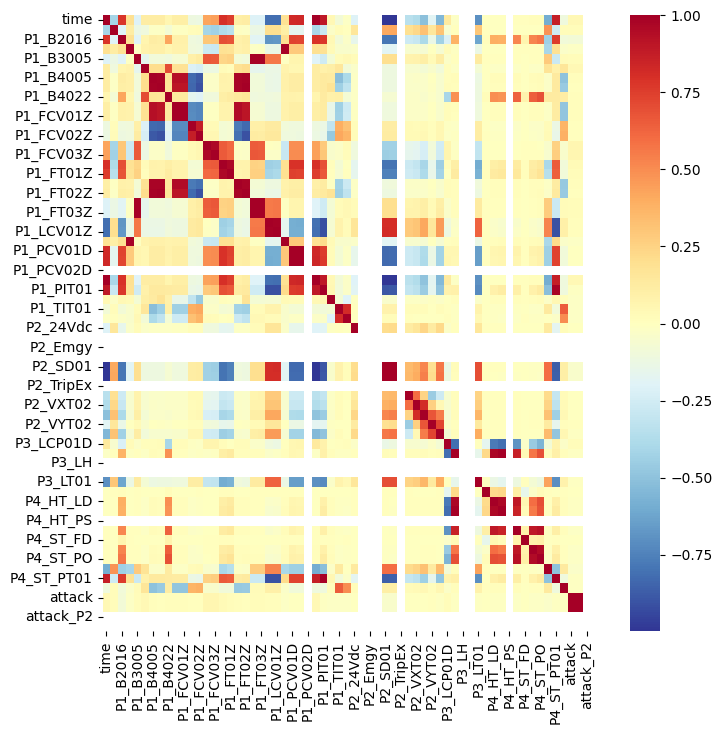

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots( figsize=(8,8,) )
sns.heatmap(total_train_data.corr(), cmap = 'RdYlBu_r')

In [ ]:
# 2. 데이터 분포 확인 함수 정의
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def statistical_analysis(data):
    mean = data.mean().round(3)  # 데이터 평균
    std = data.std().round(3)    # 데이터 표준편차
    skew = (3 * (mean - np.median(data)) / data.std()).round(3)  # 비대칭도 계산
    return mean, std, skew

<ipython-input-5-60954c58f496>:9: RuntimeWarning: invalid value encountered in scalar divide
  skew = (3 * (mean - np.median(data)) / data.std()).round(3)  # 비대칭도 계산


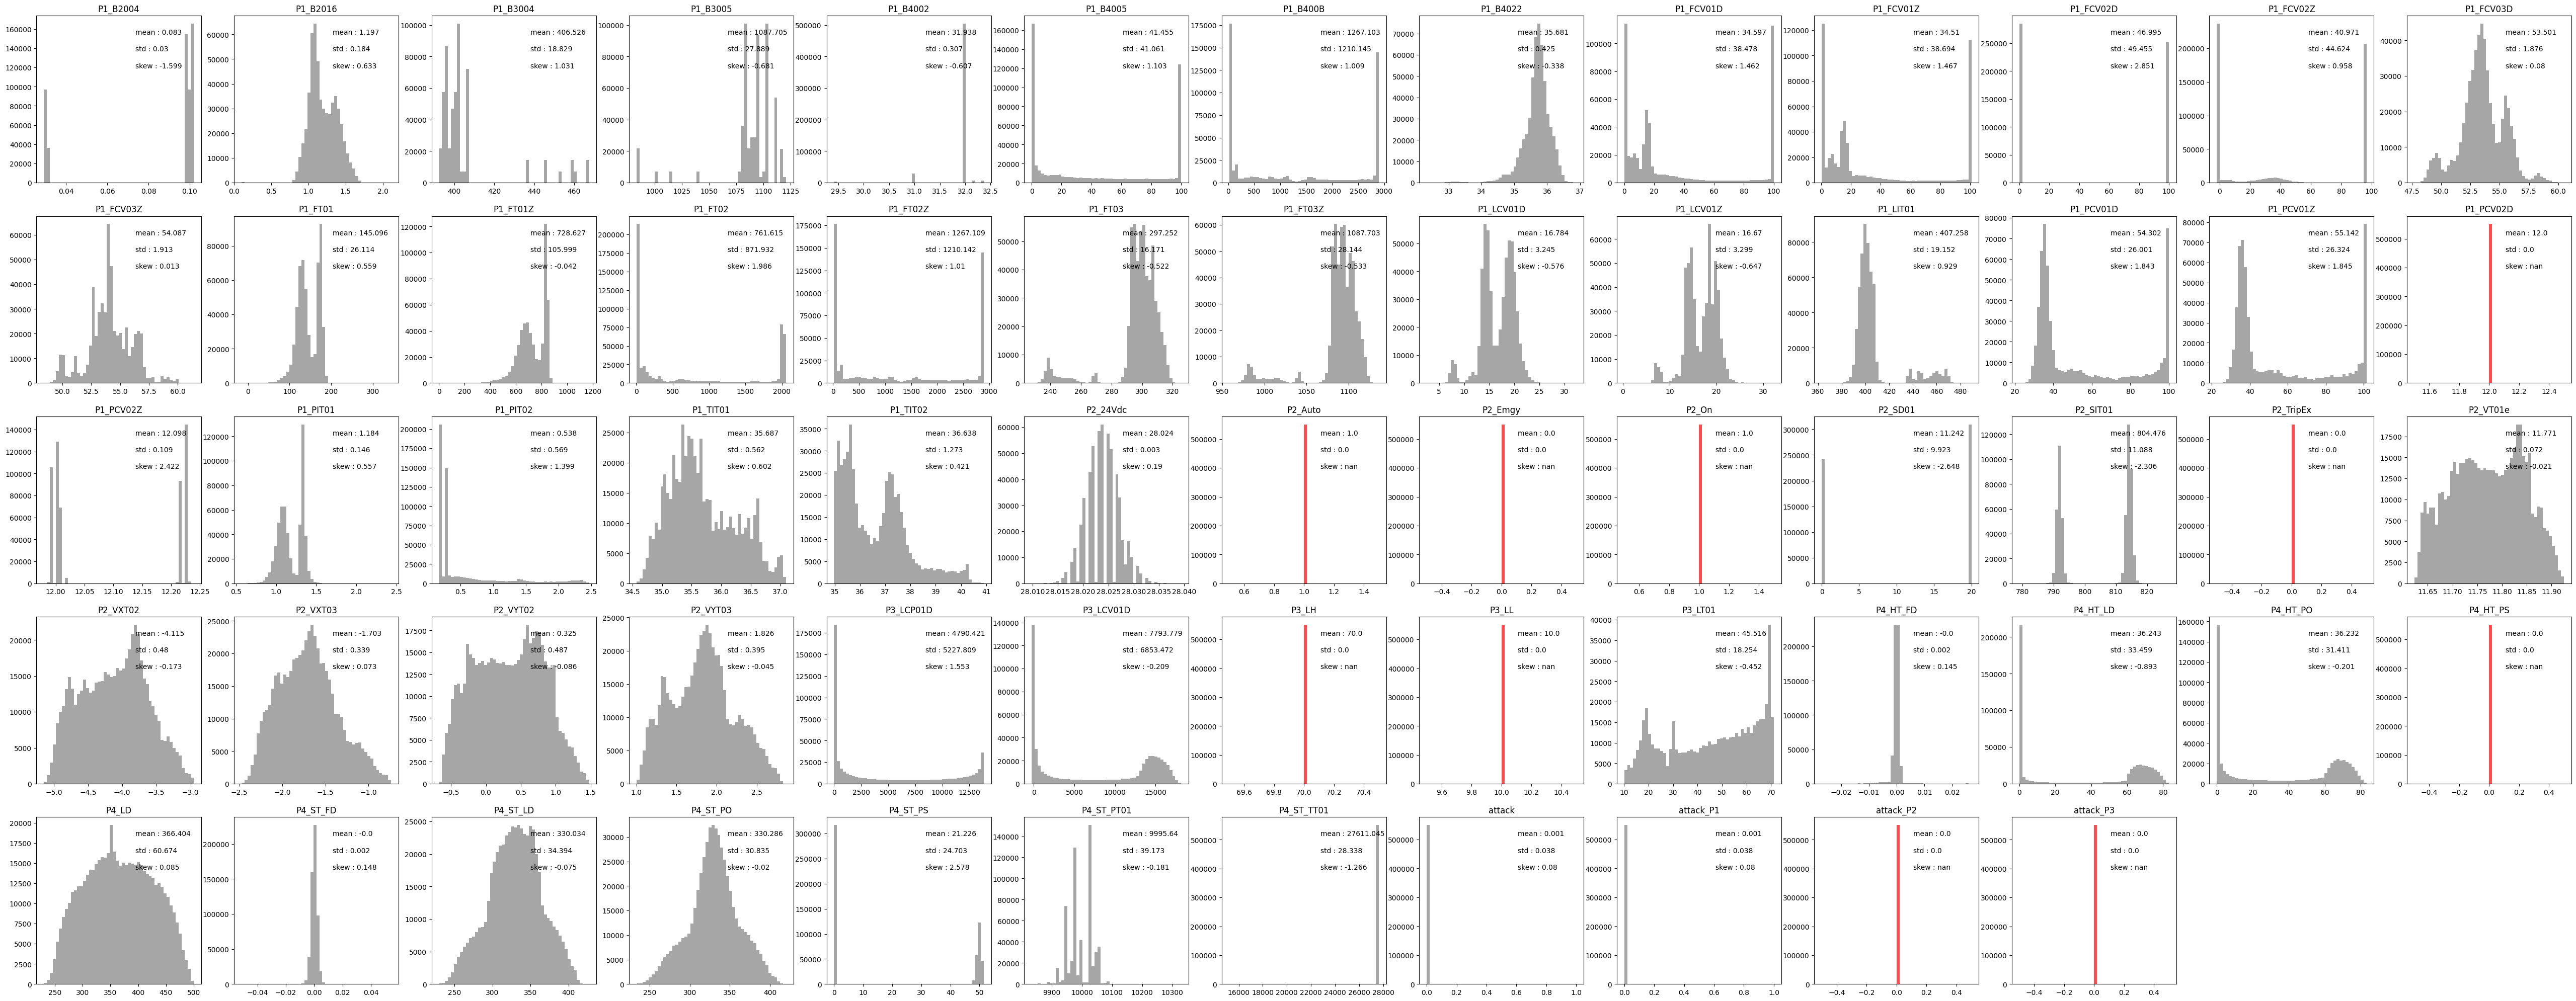

In [ ]:
fig = plt.figure(figsize = (65, 25))
for num in range(1,64):
    ax = plt.subplot(5, 13, num)
    current_column_data = total_train_data.iloc[:,num].values
    mean, std, skew = statistical_analysis(current_column_data)
    if np.isnan(skew):
        plt.hist(current_column_data, alpha = 0.7, bins = 50, color = 'red')
    else:
        plt.hist(current_column_data, alpha = 0.7, bins = 50, color = 'gray')
    plt.title(total_train_data.columns[num])
    plt.text(0.6, 0.9, f'mean : {mean}',  ha='left', va='center', transform=ax.transAxes)
    plt.text(0.6, 0.8, f'std : {std}',  ha='left', va='center', transform=ax.transAxes)
    plt.text(0.6, 0.7, f'skew : {skew}',  ha='left', va='center', transform=ax.transAxes)

In [ ]:
# 3. 동일한 값으로 이루어진 칼럼 제거
column_list = total_train_data.columns.to_list()  # Train 데이터 기준으로
useless_column_list = []
for column in column_list:
    if len(total_train_data[column].value_counts()) == 1:  # 값이 1개만 있는 칼럼 찾기
        useless_column_list.append(column)
print(useless_column_list)

['P1_PCV02D', 'P2_Auto', 'P2_Emgy', 'P2_On', 'P2_TripEx', 'P3_LH', 'P3_LL', 'P4_HT_PS', 'attack_P2', 'attack_P3']


## 2-2. 독립 변수와 종속 변수 구분

In [ ]:
# 4. FEATURE_COLUMN과 LABEL_COLUMN 정의
LABEL_COLUMN = "attack"
FEATURE_COLUMN = total_train_data.columns.drop(["time", "attack", "attack_P1", "attack_P2", "attack_P3"] + useless_column_list)

# 5. Train 데이터와 Test 데이터에서 독립변수와 종속변수 분리
X_train = total_train_data.loc[:, FEATURE_COLUMN]
y_train = total_train_data[LABEL_COLUMN]

X_test = total_test_data.loc[:, FEATURE_COLUMN]
y_test = total_test_data[LABEL_COLUMN]

# 6. 결과 확인
print("Train 독립변수 크기:", X_train.shape)
print("Train 종속변수 크기:", y_train.shape)
print("Test 독립변수 크기:", X_test.shape)
print("Test 종속변수 크기:", y_test.shape)

Train 독립변수 크기: (550800, 51)
Train 종속변수 크기: (550800,)
Test 독립변수 크기: (444600, 51)
Test 종속변수 크기: (444600,)


In [ ]:
print("train_data class proportion:", total_train_data['attack'].value_counts(normalize=True),'\n')  # 클래스 비율 확인
print("test_data class proportion:", total_test_data['attack'].value_counts(normalize=True))  # 클래스 비율 확인

train_data class proportion: attack
0    0.998591
1    0.001409
Name: proportion, dtype: float64 

test_data class proportion: attack
0    0.960578
1    0.039422
Name: proportion, dtype: float64


## 2-3. RobustScaling(X_train_scaled와 X_test_scale)

In [ ]:
# 7. 데이터 스케일링
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

## 2-4. SMOTE 적용(X_train_smote, y_train_smote)

In [ ]:
# 8. SMOTE 적용
from imblearn.over_sampling import SMOTE

# 1. SMOTE 적용
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
print("After SMOTE:", X_train_smote.shape, np.bincount(y_train_smote))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


After SMOTE: (1100048, 51) [550024 550024]


## 2-5. PCA 차원 축소

* SMOTE 적용 전 PCA(X_train_pca, X_test_pca)

In [ ]:
# 9-1. PCA 차원 축소
from sklearn.decomposition import PCA

pca = PCA(n_components=16, random_state=13)

# PCA 학습 및 변환
pca.fit(X_train_scaled)  # Scaled Train 데이터를 기반으로 PCA 학습
X_train_pca = pca.transform(X_train_scaled)  # Train 데이터 PCA 변환
X_test_pca = pca.transform(X_test_scaled)    # Test 데이터 PCA 변환

# 결과 확인
print("PCA 적용 전 Train 데이터 크기:", X_train_scaled.shape)
print("PCA 적용 후 Train 데이터 크기:", X_train_pca.shape)
print("PCA 적용 전 Test 데이터 크기:", X_test_scaled.shape)
print("PCA 적용 후 Test 데이터 크기:", X_test_pca.shape)


# PCA 결과를 DataFrame으로 변환
X_train_pca = pd.DataFrame(X_train_pca, columns=[f"PC{i+1}" for i in range(X_train_pca.shape[1])])
X_test_pca = pd.DataFrame(X_test_pca, columns=[f"PC{i+1}" for i in range(X_test_pca.shape[1])])

# 최종 확인
print("Final Train 데이터 크기:", X_train_pca.shape)
print("Final Test 데이터 크기:", X_test_pca.shape)

PCA 적용 전 Train 데이터 크기: (550800, 51)
PCA 적용 후 Train 데이터 크기: (550800, 16)
PCA 적용 전 Test 데이터 크기: (444600, 51)
PCA 적용 후 Test 데이터 크기: (444600, 16)
Final Train 데이터 크기: (550800, 16)
Final Test 데이터 크기: (444600, 16)


* SMOTE 적용 후 PCA(X_train_smote_pca, X_test_pca)

In [ ]:
# 9-2. SMOTE + PCA 적용된 변수
pca = PCA(n_components=16, random_state=13)
X_train_smote_pca = pca.fit_transform(X_train_smote)
X_test_pca = pca.transform(X_test_scaled)

# PCA 결과를 DataFrame으로 변환
X_train_smote_pca = pd.DataFrame(X_train_smote_pca, columns=[f"PC{i+1}" for i in range(X_train_smote_pca.shape[1])])
X_test_pca = pd.DataFrame(X_test_pca, columns=[f"PC{i+1}" for i in range(X_test_pca.shape[1])])

# 최종 데이터 크기 확인
print("Scaled Train Data Shape:", X_train_scaled.shape)
print("SMOTE Applied Train Data Shape:", X_train_smote.shape)
print("SMOTE + PCA Train Data Shape:", X_train_smote_pca.shape)
print("SMOTE + PCA Test Data Shape:", X_test_pca.shape)

Scaled Train Data Shape: (550800, 51)
SMOTE Applied Train Data Shape: (1100048, 51)
SMOTE + PCA Train Data Shape: (1100048, 16)
SMOTE + PCA Test Data Shape: (444600, 16)


In [ ]:
# 클래스 비율 계산
majority_class = y_train.value_counts()[0]  # 다수 클래스 (0)
minority_class = y_train.value_counts()[1]  # 소수 클래스 (1)

scale_pos_weight = majority_class / minority_class
print(f"Recommended scale_pos_weight: {scale_pos_weight:.2f}")

Recommended scale_pos_weight: 708.79


# 3. ML 모델링

## 3-1. RF, LGBM, XGBM

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import lightgbm as lgb
from TaPR_pkg import etapr  # TaPR 패키지 import

# TaPR 평가 함수 정의
def evaluate_tapr(y_true, y_pred):
    y_true_list = y_true.tolist()  # 실제 레이블 리스트
    y_pred_list = y_pred.tolist()  # 예측 레이블 리스트

    print("Calculating TaPR metrics...")
    TaPR = etapr.evaluate_haicon(anomalies=y_true_list, predictions=y_pred_list)

    # 결과 출력
    print(f"F1: {TaPR['f1']:.8f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
    print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
    print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")
    print("-" * 50)

# 1. 데이터 준비
X_train_final = X_train_split  # Train 독립변수
y_train_final = y_train_split  # Train 종속변수

X_valid_final = X_valid  # Validation 독립변수
y_valid_final = y_valid  # Validation 종속변수

# 2. 모델 초기화
rf_classifier = RandomForestClassifier(random_state=42)
xgb_classifier = xgb.XGBClassifier(random_state=42)
lgb_classifier = lgb.LGBMClassifier(random_state=42)

# 모델 리스트
classifiers = [rf_classifier, xgb_classifier, lgb_classifier]

# 3. 모델 학습/예측/평가 (TaPR 기준)
for classifier in classifiers:
    # 모델 학습
    classifier.fit(X_train_final, y_train_final)

    # Validation 데이터 예측
    pred = classifier.predict(X_valid_final)

    # 모델명 출력
    class_name = classifier.__class__.__name__
    print(f"### {class_name} ###")

    # TaPR 평가 수행
    evaluate_tapr(y_valid_final, pred)

### RandomForestClassifier ###
Calculating TaPR metrics...
F1: 0.99350649 (TaP: 1.000, TaR: 0.987)
# of detected anomalies: 153
Detected anomalies: [<TaPR_pkg.DataManage.Range.Range object at 0x7a42a4b8a230>, <TaPR_pkg.DataManage.Range.Range object at 0x7a42a4b8a710>, <TaPR_pkg.DataManage.Range.Range object at 0x7a42b238f340>, <TaPR_pkg.DataManage.Range.Range object at 0x7a42d3d70850>, <TaPR_pkg.DataManage.Range.Range object at 0x7a429233e050>, <TaPR_pkg.DataManage.Range.Range object at 0x7a429233dbd0>, <TaPR_pkg.DataManage.Range.Range object at 0x7a429233c790>, <TaPR_pkg.DataManage.Range.Range object at 0x7a429233da20>, <TaPR_pkg.DataManage.Range.Range object at 0x7a429233cbe0>, <TaPR_pkg.DataManage.Range.Range object at 0x7a429233cca0>, <TaPR_pkg.DataManage.Range.Range object at 0x7a429233d5a0>, <TaPR_pkg.DataManage.Range.Range object at 0x7a429233d330>, <TaPR_pkg.DataManage.Range.Range object at 0x7a429233e710>, <TaPR_pkg.DataManage.Range.Range object at 0x7a429233ce50>, <TaPR_pkg.D

In [ ]:
# Test 데이터 준비
X_test_final = scaled_X_test.drop(columns=['attack'])  # Test 독립변수
y_test_final = scaled_X_test['attack']  # Test 종속변수

# 1. 모델 학습 및 Test 데이터 예측/평가 (TaPR 기준)
for classifier in classifiers:
    # 모델명 출력
    class_name = classifier.__class__.__name__
    print(f"### {class_name} (Test Data) ###")

    # Test 데이터 예측
    y_test_pred = classifier.predict(X_test_final)

    # TaPR 평가 수행
    y_test_list = y_test_final.tolist()  # 실제 Test 레이블
    y_test_pred_list = y_test_pred.tolist()  # 예측된 레이블

    TaPR = etapr.evaluate_haicon(anomalies=y_test_list, predictions=y_test_pred_list)

    # 최종 결과 출력
    print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
    print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
    print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")
    print("-" * 50)

### RandomForestClassifier (Test Data) ###
F1: 0.035 (TaP: 0.129, TaR: 0.020)
# of detected anomalies: 2
Detected anomalies: [<TaPR_pkg.DataManage.Range.Range object at 0x7a42a80520e0>, <TaPR_pkg.DataManage.Range.Range object at 0x7a42a8052e30>]
--------------------------------------------------
### XGBClassifier (Test Data) ###
F1: 0.000 (TaP: 0.000, TaR: 0.000)
# of detected anomalies: 0
Detected anomalies: []
--------------------------------------------------
### LGBMClassifier (Test Data) ###
F1: 0.027 (TaP: 0.016, TaR: 0.070)
# of detected anomalies: 5
Detected anomalies: [<TaPR_pkg.DataManage.Range.Range object at 0x7a428e0b9bd0>, <TaPR_pkg.DataManage.Range.Range object at 0x7a429233ca60>, <TaPR_pkg.DataManage.Range.Range object at 0x7a42a80eec80>, <TaPR_pkg.DataManage.Range.Range object at 0x7a42a80eea40>, <TaPR_pkg.DataManage.Range.Range object at 0x7a42a80ee2c0>]
--------------------------------------------------


## 3-2. Tuned LGBM

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from TaPR_pkg import etapr

# LightGBM 모델 초기화
lgb_model = lgb.LGBMClassifier(random_state=42, scale_pos_weight=708.79)  # 소수 클래스 가중치 적용

# 하이퍼파라미터 분포 설정
param_dist = {
    'n_estimators': np.arange(100, 3001, 100),  # 결정 트리의 개수
    'learning_rate': np.arange(0.005, 0.31, 0.001),  # 학습률
    'max_depth': np.arange(5, 30, 1),  # 트리의 최대 깊이
    'subsample': np.arange(0.8, 1.01, 0.1),  # 데이터 샘플링 비율
    'colsample_bytree': np.arange(0.8, 1.01, 0.1)  # 피처 샘플링 비율
}

# RandomizedSearchCV 초기화
random_search_lgb = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist,
    n_iter=50,  # 50개의 무작위 하이퍼파라미터 조합 시도
    scoring='recall',  # Recall 기준으로 성능 평가
    cv=5,  # 5-Fold 교차 검증
    verbose=2,  # 상세 로그 출력
    random_state=42
)

# Train 데이터로 하이퍼파라미터 튜닝 수행
print("Starting RandomizedSearchCV for LightGBM...")
random_search_lgb.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("Optimal Hyperparameters:", random_search_lgb.best_params_)

# 최적의 모델을 Test 데이터에서 평가
best_lgb = random_search_lgb.best_estimator_

# Test 데이터 예측
y_test_pred = best_lgb.predict(X_test)
y_test_pred_list = y_test_pred.tolist()
y_test_true_list = y_test.tolist()

# Test 데이터에서 TaPR 평가
print("\n### Test 데이터 TaPR 평가 ###")
TaPR_test = etapr.evaluate_haicon(anomalies=y_test_true_list, predictions=y_test_pred_list)
print(f"F1: {TaPR_test['f1']:.3f} (TaP: {TaPR_test['TaP']:.3f}, TaR: {TaPR_test['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR_test['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR_test['Detected_Anomalies']}")

Starting RandomizedSearchCV for LightGBM...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bytree=0.8, learning_rate=0.059, max_depth=10, n_estimators=300, subsample=1.0; total time=   5.0s
[CV] END colsample_bytree=0.8, learning_rate=0.059, max_depth=10, n_estimators=300, subsample=1.0; total time=   4.7s
[CV] END colsample_bytree=0.8, learning_rate=0.059, max_depth=10, n_estimators=300, subsample=1.0; total time=   4.5s
[CV] END colsample_bytree=0.8, learning_rate=0.059, max_depth=10, n_estimators=300, subsample=1.0; total time=   4.4s
[CV] END colsample_bytree=0.8, learning_rate=0.059, max_depth=10, n_estimators=300, subsample=1.0; total time=   4.7s
[CV] END colsample_bytree=0.8, learning_rate=0.303, max_depth=12, n_estimators=900, subsample=0.9; total time=   9.7s
[CV] END colsample_bytree=0.8, learning_rate=0.303, max_depth=12, n_estimators=900, subsample=0.9; total time=   9.5s
[CV] END colsample_bytree=0.8, learning_rate=0.303, max_depth=12, n_

## 3-3. Tuned CatBoost

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from TaPR_pkg import etapr

# CatBoost 모델 초기화
cat_model = CatBoostClassifier(
    random_state=42,
    verbose=0,  # 학습 로그 최소화
    scale_pos_weight=708.79  # 소수 클래스 가중치 적용
)

# 하이퍼파라미터 분포 설정
param_dist = {
    'iterations': np.arange(500, 3001, 500),  # 트리 개수
    'learning_rate': np.arange(0.01, 0.3, 0.01),  # 학습률
    'depth': np.arange(4, 12, 1),  # 트리 깊이
    'l2_leaf_reg': np.arange(1, 10, 1),  # L2 정규화
    'bagging_temperature': np.arange(0, 1.1, 0.1)  # 배깅 온도
}

# RandomizedSearchCV 초기화
random_search_cat = RandomizedSearchCV(
    estimator=cat_model,
    param_distributions=param_dist,
    n_iter=50,  # 50개의 무작위 조합
    scoring='roc_auc',  # ROC-AUC 기준
    cv=3,  # 3-Fold 교차 검증
    verbose=2,  # 상세 로그 출력
    n_jobs=-1,  # 모든 CPU 코어 사용
    random_state=42
)

# Train 데이터로 하이퍼파라미터 튜닝 수행
print("Starting RandomizedSearchCV for CatBoost...")
random_search_cat.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("Optimal Hyperparameters for CatBoost:", random_search_cat.best_params_)

# 최적의 모델 추출
best_cat = random_search_cat.best_estimator_

# Validation 데이터에서 CatBoost 성능 평가
y_valid_pred = best_cat.predict(X_test)
y_test_pred_list = y_test_pred.tolist()
y_test_true_list = y_test.tolist()

print("\n### Validation 데이터 TaPR 평가 (CatBoost) ###")
TaPR_valid = etapr.evaluate_haicon(anomalies=y_test_true_list, predictions=y_test_pred_list)
print(f"F1: {TaPR_valid['f1']:.3f} (TaP: {TaPR_valid['TaP']:.3f}, TaR: {TaPR_valid['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR_valid['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR_valid['Detected_Anomalies']}")

# Test 데이터에서 CatBoost 최종 평가
X_test_final = scaled_X_test.drop(columns=['attack'])  # Test 독립변수
y_test_final = scaled_X_test['attack']  # Test 종속변수

y_test_pred = best_cat.predict(X_test_final)
y_test_pred_list = y_test_pred.tolist()
y_test_true_list = y_test_final.tolist()

print("\n### Test 데이터 TaPR 평가 (CatBoost) ###")
TaPR_test = etapr.evaluate_haicon(anomalies=y_test_true_list, predictions=y_test_pred_list)
print(f"F1: {TaPR_test['f1']:.3f} (TaP: {TaPR_test['TaP']:.3f}, TaR: {TaPR_test['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR_test['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR_test['Detected_Anomalies']}")

## 3-4. 모델링을 위한 데이터 종속 변수 추가


In [ ]:
# Train과 Test 데이터를 DataFrame으로 변환 (Robust 스케일링된 데이터 사용)
train_data = scaled_X_train.copy()  # 스케일링된 Train 독립변수
train_data['attack'] = y_train.reset_index(drop=True)  # 종속변수 추가

test_data = scaled_X_test.copy()  # 스케일링된 Test 독립변수
test_data['attack'] = y_test.reset_index(drop=True)  # 종속변수 추가

# 결과 확인
print("Train 데이터 shape:", train_data.shape)
print("Test 데이터 shape:", test_data.shape)
print("Train 데이터 예시:")
print(train_data.head())

Train 데이터 shape: (550800, 52)
Test 데이터 shape: (444600, 52)
Train 데이터 예시:
   P1_B2004  P1_B2016  P1_B3004  P1_B3005  P1_B4002  P1_B4005  P1_B400B  \
0 -0.230769 -0.307934 -0.079057   0.85154       0.0 -0.289025 -0.295768   
1 -0.230769 -0.308983 -0.079057   0.85154       0.0 -0.289025 -0.295414   
2 -0.230769 -0.307585 -0.079057   0.85154       0.0 -0.289025 -0.296474   
3 -0.230769 -0.301992 -0.079057   0.85154       0.0 -0.289025 -0.294354   
4 -0.230769 -0.305138 -0.079057   0.85154       0.0 -0.289025 -0.295061   

   P1_B4022  P1_FCV01D  P1_FCV01Z  ...  P4_HT_LD  P4_HT_PO     P4_LD  \
0  0.026973  -0.239884  -0.230734  ...  0.265213  0.291735  0.314281   
1  0.025208  -0.239884  -0.230734  ...  0.268997  0.300920  0.348389   
2  0.027981  -0.239884  -0.230620  ...  0.272254  0.312534  0.343890   
3  0.041341  -0.239884  -0.230849  ...  0.275407  0.320908  0.351762   
4  0.033779  -0.239884  -0.230734  ...  0.279401  0.328202  0.378749   

   P4_ST_FD  P4_ST_LD  P4_ST_PO  P4_ST_PS  

In [ ]:
# # PCA 적용된 Train과 Test 데이터를 DataFrame으로 변환
# train_data = X_train_final.copy()  # X_train_final: PCA 적용된 Train 데이터
# train_data['attack'] = y_train_resampled.reset_index(drop=True)  # 종속변수 추가

# test_data = X_test_final.copy()  # X_test_final: PCA 적용된 Test 데이터
# test_data['attack'] = y_test.reset_index(drop=True)  # 종속변수 추가

# # 결과 확인
# print("Train 데이터 shape:", train_data.shape)
# print("Test 데이터 shape:", test_data.shape)
# print("Train 데이터 예시:")
# print(train_data.head())

Train 데이터 shape: (1100048, 17)
Test 데이터 shape: (444600, 17)
Train 데이터 예시:
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  2.534921  1.695184 -0.784850 -0.846158  0.997232 -0.557080  1.898439   
1  2.549650  1.698712 -0.810418 -0.860065  1.010877 -0.716141  1.976397   
2  2.516512  1.674007 -0.817505 -0.726680  0.962502 -0.502985  1.924246   
3  2.551304  1.658790 -0.860135 -0.676784  1.030935 -0.709604  2.209833   
4  2.515873  1.674337 -0.862232 -0.623691  0.956473 -0.501150  1.983399   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0  1.723225  0.304616 -1.173154  1.188351  0.487918 -0.457830 -0.334232   
1  1.772673  0.395269 -1.458719 -1.048794 -0.232671 -0.249052 -0.489283   
2  1.774575  0.264415 -0.966103  1.309330 -0.331214 -0.289728  0.592307   
3  1.882345  0.458337 -1.525787 -0.291864  0.571145 -0.680870  1.116333   
4  1.847354  0.325355 -1.052959  0.230306 -0.957511 -0.089138  0.580851   

       PC15      PC16  a

## 3-5. 데이터 학습: Medium-Quality

In [ ]:
from autogluon.tabular import TabularPredictor
import pandas as pd

from autogluon.tabular import TabularPredictor

# AutoGluon 모델 학습
predictor = TabularPredictor(
    label='attack',        # 종속변수
    eval_metric='recall',  # 평가 지표: Recall (이상 탐지 문제에 적합)
    problem_type='binary', # 이진 분류 문제
    path='model_path/'     # 모델 저장 경로
).fit(
    train_data=train_data,  # 학습 데이터 그대로 사용
    time_limit=21600,         # 최대 학습 시간 (초)
    presets='medium_quality',  # 최고 품질 모델링
)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          12
Memory Avail:       75.57 GB / 83.48 GB (90.5%)
Disk Space Avail:   201.38 GB / 235.68 GB (85.4%)
Presets specified: ['medium_quality']
Beginning AutoGluon training ... Time limit = 21600s
AutoGluon will save models to "/content/model_path"
Train Data Rows:    1100048
Train Data Columns: 16
Label Column:       attack
Problem Type:       binary
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    77372.09 MB
	Train Data (Original)  Memory Usage: 134.28 MB (0.2% of available memory)
	Inferring data type of each feature based on column values. Set fe

 3-3. 최적의 모델 정보 출력

In [ ]:
# 모델 저장 경로 출력
print(f"Model saved to: {predictor.path}")

# 최적 모델 확인
model_best = predictor.model_best
print(f"Best model used by AutoGluon: {model_best}")

# 최적 모델의 추가 정보 출력
print("Details of the best model:")
best_model_info = predictor.info()['model_info'][model_best]
print(best_model_info)

Model saved to: /content/model_path
Best model used by AutoGluon: WeightedEnsemble_L2
Details of the best model:
{'name': 'WeightedEnsemble_L2', 'model_type': 'WeightedEnsembleModel', 'problem_type': 'binary', 'eval_metric': 'recall', 'stopping_metric': 'recall', 'fit_time': 1.2466297149658203, 'num_classes': 2, 'quantile_levels': None, 'predict_time': 0.004522800445556641, 'val_score': 1.0, 'hyperparameters': {'use_orig_features': False, 'valid_stacker': True, 'max_base_models': 0, 'max_base_models_per_type': 'auto', 'save_bag_folds': True}, 'hyperparameters_fit': {}, 'hyperparameters_nondefault': ['save_bag_folds'], 'ag_args_fit': {'max_memory_usage_ratio': 1.0, 'max_time_limit_ratio': 1.0, 'max_time_limit': None, 'min_time_limit': 0, 'valid_raw_types': None, 'valid_special_types': None, 'ignored_type_group_special': None, 'ignored_type_group_raw': None, 'get_features_kwargs': None, 'get_features_kwargs_extra': None, 'predict_1_batch_size': None, 'temperature_scalar': None, 'drop_uni

3-4. 모델 성능 평가

In [ ]:
import numpy as np
from sklearn.metrics import f1_score

# Test 데이터 예측 확률
y_pred_proba = predictor.predict_proba(test_data.drop(columns=['attack'])).iloc[:, 1]

# Threshold 탐색
thresholds = np.arange(0.05, 1.0, 0.05)
best_threshold = 0.0
best_f1 = 0.0

for threshold in thresholds:
    y_pred = (y_pred_proba > threshold).astype(int)
    f1 = f1_score(test_data['attack'], y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Best Threshold: {best_threshold}, Best F1: {best_f1:.4f}")


In [ ]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

# 예측 확률
y_pred_proba = predictor.predict_proba(input_data).iloc[:, 1]

# Threshold 탐색
thresholds = np.arange(0.1, 1.0, 0.05)  # 0.1부터 1.0까지 0.05 간격으로 시도
best_threshold = 0.0
best_f1 = 0.0

print("Threshold 탐색 중...")
for threshold in thresholds:
    y_test_pred = (y_pred_proba > threshold).astype(int)
    f1 = f1_score(y_test, y_test_pred)

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

    print(f"Threshold: {threshold:.2f}, F1: {f1:.4f}")

# 최적 Threshold 결과
print(f"\nBest Threshold: {best_threshold:.2f}, Best F1: {best_f1:.4f}")

# 최적 Threshold로 최종 예측
y_test_pred_optimal = (y_pred_proba > best_threshold).astype(int)

# TaPR 계산
y_test_list = y_test.tolist()
y_test_pred_list = y_test_pred_optimal.tolist()

print("Calculating TaPR metrics...")
TaPR = etapr.evaluate_haicon(anomalies=y_test_list, predictions=y_test_pred_list)

# 최종 결과 출력
print(f"F1: {TaPR['f1']:.8f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

Threshold 탐색 중...
Threshold: 0.10, F1: 0.1841
Threshold: 0.15, F1: 0.1838
Threshold: 0.20, F1: 0.1883
Threshold: 0.25, F1: 0.1862
Threshold: 0.30, F1: 0.1755
Threshold: 0.35, F1: 0.1712
Threshold: 0.40, F1: 0.1635
Threshold: 0.45, F1: 0.1547
Threshold: 0.50, F1: 0.1424
Threshold: 0.55, F1: 0.1335
Threshold: 0.60, F1: 0.1260
Threshold: 0.65, F1: 0.1191
Threshold: 0.70, F1: 0.0935
Threshold: 0.75, F1: 0.0839
Threshold: 0.80, F1: 0.0688
Threshold: 0.85, F1: 0.0507
Threshold: 0.90, F1: 0.0352
Threshold: 0.95, F1: 0.0183

Best Threshold: 0.20, Best F1: 0.1883
Calculating TaPR metrics...
F1: 0.02495326 (TaP: 0.014, TaR: 0.156)
# of detected anomalies: 12
Detected anomalies: [<TaPR_pkg.DataManage.Range.Range object at 0x7b3aa662e950>, <TaPR_pkg.DataManage.Range.Range object at 0x7b3aa666b8b0>, <TaPR_pkg.DataManage.Range.Range object at 0x7b3aa189d5d0>, <TaPR_pkg.DataManage.Range.Range object at 0x7b3aa189e6b0>, <TaPR_pkg.DataManage.Range.Range object at 0x7b3aa189fd30>, <TaPR_pkg.DataManage.R

In [ ]:
from TaPR_pkg import etapr
import pandas as pd

# 입력 데이터 준비
input_data = test_data.drop(columns=['attack'])  # 테스트 데이터에서 'attack' 열 제외
y_test = test_data['attack']  # 실제 레이블 저장

# 최적 모델로 예측 수행
print("Performing predictions...")
y_test_pred = predictor.predict(input_data,  model=model_best)  # 최적 모델로 예측 수행

# 예측 결과 확인 (0 또는 1인지 확인)
print(f"Unique values in predictions: {y_test_pred.unique()}")

# 리스트 변환
y_test_list = y_test.tolist()
y_test_pred_list = y_test_pred.astype(int).tolist()  # 정수형으로 변환 후 리스트화

# TaPR 지표 계산
print("Calculating TaPR metrics...")
TaPR = etapr.evaluate_haicon(anomalies=y_test_list, predictions=y_test_pred_list)


# 결과 출력
print(f"F1: {TaPR['f1']:.8f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR.get('Detected_Anomalies', []))}")
print(f"Detected anomalies: {TaPR.get('Detected_Anomalies', [])}")


## 3-6. 데이터 학습: High-Quality

In [ ]:
from autogluon.tabular import TabularPredictor

# AutoGluon 모델 학습 (high_quality 적용)
predictor = TabularPredictor(
    label='attack',         # 종속변수
    eval_metric='recall',   # 평가 지표: Recall
    problem_type='binary',  # 이진 분류 문제
    path='model_path_high/' # 모델 저장 경로
).fit(
    train_data=train_data,  # 학습 데이터 그대로 사용
    time_limit=21600,       # 최대 학습 시간 (6시간)
    presets='high_quality', # 높은 품질의 모델링
    hyperparameters={
        'GBM': {'scale_pos_weight': 10}}  # 소수 클래스 가중치
)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          12
Memory Avail:       77.34 GB / 83.48 GB (92.7%)
Disk Space Avail:   201.76 GB / 235.68 GB (85.6%)
Presets specified: ['high_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Note: `save_bag_folds=False`! This will greatly reduce peak disk usage during fit (by ~8x), but runs the risk of an out-of-memory error during model refit if memory is small relative to the data size.
	You can avoid this risk by setting `save_bag_folds=True`.
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input d

In [ ]:
from TaPR_pkg import etapr  # TaPR 패키지 import

# Test 데이터 준비
input_data = test_data.drop(columns=['attack'])  # Test 독립변수 (스케일링된 데이터 사용)
y_test = test_data['attack'].reset_index(drop=True)  # Test 종속변수 (레이블)

# AutoGluon 모델로 예측 수행 (0 또는 1 예측값 반환)
y_test_pred = predictor.predict(input_data, model=model_best)  # 확률이 아닌 최종 예측값 사용

# pandas.Series를 리스트로 변환
y_test_list = y_test.tolist()
y_test_pred_list = y_test_pred.tolist()

# TaPR 평가
print("Calculating TaPR metrics...")
TaPR = etapr.evaluate_haicon(anomalies=y_test_list, predictions=y_test_pred_list)

# 최종 결과 출력
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

Threshold 탐색 중...
Threshold: 0.10, F1: 0.0000
Threshold: 0.15, F1: 0.0000
Threshold: 0.20, F1: 0.0000
Threshold: 0.25, F1: 0.0000
Threshold: 0.30, F1: 0.0000
Threshold: 0.35, F1: 0.0000
Threshold: 0.40, F1: 0.0000
Threshold: 0.45, F1: 0.0000
Threshold: 0.50, F1: 0.0000
Threshold: 0.55, F1: 0.0000
Threshold: 0.60, F1: 0.0000
Threshold: 0.65, F1: 0.0000
Threshold: 0.70, F1: 0.0000
Threshold: 0.75, F1: 0.0000
Threshold: 0.80, F1: 0.0000
Threshold: 0.85, F1: 0.0000
Threshold: 0.90, F1: 0.0000
Threshold: 0.95, F1: 0.0000

Best Threshold: 0.00, Best F1: 0.0000
Calculating TaPR metrics...
F1: 0.00000000 (TaP: 0.000, TaR: 0.000)
# of detected anomalies: 0
Detected anomalies: []


## 3-7. 데이터 학습: Best-Quality

In [ ]:
from autogluon.tabular import TabularPredictor

# scale_pos_weight를 여러 값으로 조정하며 실험
for weight in [10, 50, 100, 200, 500, 700]:
    print(f"Training with scale_pos_weight: {weight}")
    predictor = TabularPredictor(
        label='attack',
        eval_metric='recall',
        path=f'model_path_weight_{weight}/'
    ).fit(
        train_data=train_data,
        time_limit=7200,  # 예시로 2시간 제한
        presets='best_quality',
        hyperparameters={
            'GBM': {'scale_pos_weight': weight}
        }
    )


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          12
Memory Avail:       75.55 GB / 83.48 GB (90.5%)
Disk Space Avail:   201.53 GB / 235.68 GB (85.5%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect stack

Training with scale_pos_weight: 10


Leaderboard on holdout data (DyStack):
                 model  score_holdout  score_val eval_metric  pred_time_test  pred_time_val   fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      LightGBM_BAG_L1            1.0   0.991304      recall        1.093333       0.250655  10.657486                 1.093333                0.250655          10.657486            1       True          1
1  WeightedEnsemble_L2            1.0   0.991304      recall        1.096293       0.535430  10.955009                 0.002961                0.284775           0.297523            2       True          2
2      LightGBM_BAG_L2            1.0   0.992754      recall        1.296599       0.496851  21.629123                 0.203266                0.246196          10.971637            2       True          3
3  WeightedEnsemble_L3            1.0   0.992754      recall        1.299048       0.793606  35.722667                 0.002450          

Training with scale_pos_weight: 50


Leaderboard on holdout data (DyStack):
                 model  score_holdout  score_val eval_metric  pred_time_test  pred_time_val   fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      LightGBM_BAG_L1            1.0   0.992754      recall        1.111338       0.333981  12.798688                 1.111338                0.333981          12.798688            1       True          1
1  WeightedEnsemble_L2            1.0   0.992754      recall        1.114245       0.618412  13.092106                 0.002907                0.284431           0.293418            2       True          2
2      LightGBM_BAG_L2            1.0   0.997101      recall        1.314109       0.627317  25.546123                 0.202771                0.293337          12.747435            2       True          3
3  WeightedEnsemble_L3            1.0   0.997101      recall        1.316660       0.913707  39.485509                 0.002551          

Training with scale_pos_weight: 100


Leaderboard on holdout data (DyStack):
                 model  score_holdout  score_val eval_metric  pred_time_test  pred_time_val   fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      LightGBM_BAG_L1            1.0   0.989855      recall        1.189776       0.281404  10.867054                 1.189776                0.281404          10.867054            1       True          1
1  WeightedEnsemble_L2            1.0   0.989855      recall        1.192745       0.592762  11.172259                 0.002969                0.311358           0.305204            2       True          2
2      LightGBM_BAG_L2            1.0   0.995652      recall        1.377630       0.580743  22.031853                 0.187855                0.299339          11.164799            2       True          3
3  WeightedEnsemble_L3            1.0   0.995652      recall        1.380327       0.863307  36.185735                 0.002696          

Training with scale_pos_weight: 200


	
	1	 = Optimal   num_stack_levels (Stacked Overfitting Occurred: False)
	64s	 = DyStack   runtime |	7136s	 = Remaining runtime
Starting main fit with num_stack_levels=1.
	For future fit calls on this dataset, you can skip DyStack to save time: `predictor.fit(..., dynamic_stacking=False, num_stack_levels=1)`
Beginning AutoGluon training ... Time limit = 7136s
AutoGluon will save models to "/content/model_path_weight_200"
Train Data Rows:    550800
Train Data Columns: 51
Label Column:       attack
Problem Type:       binary
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    77359.74 MB
	Train Data (Original)  Memory Usage: 214.32 MB (0.3% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting 

Training with scale_pos_weight: 500


Leaderboard on holdout data (DyStack):
                 model  score_holdout  score_val eval_metric  pred_time_test  pred_time_val   fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      LightGBM_BAG_L1            1.0   0.988406      recall        1.111519       0.314205  11.564245                 1.111519                0.314205          11.564245            1       True          1
1  WeightedEnsemble_L2            1.0   0.988406      recall        1.114491       0.602574  11.860562                 0.002971                0.288369           0.296317            2       True          2
2      LightGBM_BAG_L2            1.0   0.991304      recall        1.305211       0.571234  22.699334                 0.193692                0.257029          11.135089            2       True          3
3  WeightedEnsemble_L3            1.0   0.991304      recall        1.307844       0.864401  36.582085                 0.002632          

Training with scale_pos_weight: 700


Leaderboard on holdout data (DyStack):
                 model  score_holdout  score_val eval_metric  pred_time_test  pred_time_val   fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      LightGBM_BAG_L1            1.0   0.991304      recall        1.084849       0.243012  10.637151                 1.084849                0.243012          10.637151            1       True          1
1  WeightedEnsemble_L2            1.0   0.991304      recall        1.087835       0.531233  10.939079                 0.002985                0.288221           0.301928            2       True          2
2      LightGBM_BAG_L2            1.0   0.994203      recall        1.281867       0.493867  21.648187                 0.197018                0.250854          11.011036            2       True          3
3  WeightedEnsemble_L3            1.0   0.994203      recall        1.284345       0.792486  35.360142                 0.002478          

In [ ]:
# 모델 저장 경로 출력
print(f"Model saved to: {predictor.path}")

# 최적 모델 확인
model_best = predictor.model_best
print(f"Best model used by AutoGluon: {model_best}")

# 최적 모델의 추가 정보 출력
print("Details of the best model:")
best_model_info = predictor.info()['model_info'][model_best]
print(best_model_info)

Model saved to: /content/model_path_weight_700
Best model used by AutoGluon: WeightedEnsemble_L2
Details of the best model:
{'name': 'WeightedEnsemble_L2', 'model_type': 'WeightedEnsembleModel', 'problem_type': 'binary', 'eval_metric': 'recall', 'stopping_metric': 'recall', 'fit_time': 0.3203444480895996, 'num_classes': 2, 'quantile_levels': None, 'predict_time': 0.3132946491241455, 'val_score': 0.990979381443299, 'hyperparameters': {'use_orig_features': False, 'valid_stacker': True, 'max_base_models': 0, 'max_base_models_per_type': 'auto', 'save_bag_folds': True}, 'hyperparameters_fit': {}, 'hyperparameters_nondefault': ['save_bag_folds'], 'ag_args_fit': {'max_memory_usage_ratio': 1.0, 'max_time_limit_ratio': 1.0, 'max_time_limit': None, 'min_time_limit': 0, 'valid_raw_types': None, 'valid_special_types': None, 'ignored_type_group_special': None, 'ignored_type_group_raw': None, 'get_features_kwargs': None, 'get_features_kwargs_extra': None, 'predict_1_batch_size': None, 'temperature_s

In [ ]:
from TaPR_pkg import etapr  # TaPR 패키지 import

# Test 데이터 준비
input_data = test_data.drop(columns=['attack'])  # Test 독립변수 (스케일링된 데이터 사용)
y_test = test_data['attack'].reset_index(drop=True)  # Test 종속변수 (레이블)

# AutoGluon 모델로 예측 수행 (0 또는 1 예측값 반환)
y_test_pred = predictor.predict(input_data, model=model_best)  # 확률이 아닌 최종 예측값 사용

# pandas.Series를 리스트로 변환
y_test_list = y_test.tolist()
y_test_pred_list = y_test_pred.tolist()

# TaPR 평가
print("Calculating TaPR metrics...")
TaPR = etapr.evaluate_haicon(anomalies=y_test_list, predictions=y_test_pred_list)

# 최종 결과 출력
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

Calculating TaPR metrics...
F1: 0.000 (TaP: 0.000, TaR: 0.000)
# of detected anomalies: 0
Detected anomalies: []


# 4. DL 모델링

## 4-1 MLP

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from sklearn.metrics import f1_score, recall_score, precision_score
import numpy as np

# 클래스 가중치 계산
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weight_dict)

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',   # Validation Loss 기준
    patience=5,           # 5 Epoch 동안 개선이 없으면 중단
    restore_best_weights=True,  # 가장 좋은 가중치를 복원
    verbose=1
)

# 확장된 MLP 모델 정의
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),  # 첫 번째 은닉층
    Dropout(0.4),
    Dense(128, activation='relu'),  # 두 번째 은닉층
    Dropout(0.3),
    Dense(64, activation='relu'),   # 세 번째 은닉층
    Dropout(0.3),
    Dense(32, activation='relu'),   # 네 번째 은닉층
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # 출력층 (이진 분류)
])

# 모델 컴파일
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['Recall']
)

# 모델 학습 (EarlyStopping 적용)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    class_weight=class_weight_dict,
    epochs=50,                 # 최대 50 Epoch
    batch_size=1024,
    callbacks=[early_stopping],  # EarlyStopping 콜백 추가
    verbose=1
)

print("\nModel Training Complete.")

# 모델 예측 및 Threshold 조정
y_test_pred_proba = model.predict(X_test)
threshold = 0.3  # Threshold 설정
y_test_pred = (y_test_pred_proba > threshold).astype(int)

# 평가 지표
print("\n### 모델 평가 ###")
print("Recall:", recall_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("F1 Score:", f1_score(y_test, y_test_pred))


## 4-2 Auto-Encoder

#### 4-2.0.1 Robust Scale+SMOTE 적용

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.preprocessing import RobustScaler
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
from TaPR_pkg import etapr
import numpy as np

# 1. 데이터 준비 및 스케일링
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SMOTE로 소수 클래스 오버샘플링
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
print("After SMOTE:", X_train_resampled.shape, np.bincount(y_train_resampled))

# 클래스 가중치 계산
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_resampled),
    y=y_train_resampled
)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weight_dict)

# 2. AutoEncoder 모델 구축
input_layer = Input(shape=(X_train.shape[1],))
encoder = Dense(128, activation='relu')(input_layer)
encoder = Dense(64, activation='relu')(encoder)
encoder = Dense(32, activation='relu')(encoder)  # Bottleneck Layer
decoder = Dense(64, activation='relu')(encoder)
decoder = Dense(128, activation='relu')(decoder)
output_layer = Dense(X_train.shape[1], activation='linear')(decoder)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

# 3. 모델 학습 (클래스 가중치 적용)
autoencoder.fit(
    X_train_resampled, X_train_resampled,
    epochs=50, batch_size=1024,
    validation_split=0.2,
    class_weight=class_weight_dict,
    verbose=1
)

# 4. Test 데이터 재구성 및 재구성 오류 계산
X_test_pred = autoencoder.predict(X_test_scaled)
reconstruction_error = np.mean(np.square(X_test_scaled - X_test_pred), axis=1)

# 5. Threshold 설정 (상위 5% 기준)
threshold = np.percentile(reconstruction_error, 95)  # 상위 5%를 기준으로 설정
print(f"Threshold for anomaly detection (95%): {threshold:.4f}")

# 상위 2% 기준 Threshold 추가
threshold1 = np.percentile(reconstruction_error, 98)  # 상위 2%를 기준으로 설정
print(f"Threshold for anomaly detection (98%): {threshold1:.4f}")

# 6. 이상치 탐지 (상위 5% 기준)
y_test_pred = (reconstruction_error > threshold).astype(int)

# 이상치 탐지 (상위 2% 기준)
y_test_pred1 = (reconstruction_error > threshold1).astype(int)

# 7. TaPR 평가 지표 적용 - 95% 기준
print("\n### Test 데이터 TaPR 평가 (95% 기준) ###")
y_test_list = y_test.tolist()
y_test_pred_list = y_test_pred.tolist()
TaPR = etapr.evaluate_haicon(anomalies=y_test_list, predictions=y_test_pred_list)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

# 8. TaPR 평가 지표 적용 - 98% 기준
print("\n### Test 데이터 TaPR 평가 (98% 기준) ###")
y_test_pred1_list = y_test_pred1.tolist()
TaPR1 = etapr.evaluate_haicon(anomalies=y_test_list, predictions=y_test_pred1_list)
print(f"F1: {TaPR1['f1']:.3f} (TaP: {TaPR1['TaP']:.3f}, TaR: {TaPR1['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR1['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR1['Detected_Anomalies']}")

After SMOTE: (1100048, 51) [550024 550024]
Class Weights: {0: 1.0, 1: 1.0}
Epoch 1/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 45s 32ms/step - loss: 0.4158 - val_loss: 0.0057
Epoch 2/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0138 - val_loss: 0.0080
Epoch 3/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0388 - val_loss: 0.0036
Epoch 4/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0211 - val_loss: 0.0029
Epoch 5/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0196 - val_loss: 0.0027
Epoch 6/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0077 - val_loss: 0.0095
Epoch 7/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0280 - val_loss: 0.0027
Epoch 8/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0259 - val_loss: 0.0020
Epoch 9/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0087 - val_loss: 0.0017
Epoch 10/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0062 - val_loss: 0.0016
Epoch 11/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0

In [ ]:
import pandas as pd

# 1. y_test_pred1 (98% 기준 예측치)를 DataFrame으로 변환
y_test_pred1_df = pd.DataFrame(y_test_pred1, columns=["attack"])

# 2. total_test_data에서 "time" 칼럼 추출 및 포맷 수정
time_data = total_test_data["time"]
time_data = pd.to_datetime(time_data).dt.floor('min').dt.strftime('%Y-%m-%d %H:%M:%S')

# 3. "time"과 y_test_pred1 결합
submission = pd.concat([time_data.reset_index(drop=True), y_test_pred1_df.reset_index(drop=True)], axis=1)
submission.columns = ["timestamp", "attack"]

# 4. 결과를 지정된 경로로 저장
save_path = "/content/drive/MyDrive/2024-2/AI_HAI/20203675_1218am1.csv"
submission.to_csv(save_path, index=False)

print(f"CSV 파일이 저장되었습니다: {save_path}")

CSV 파일이 저장되었습니다: /content/drive/MyDrive/2024-2/AI_HAI/20203675_1218am1.csv


#### 4-2.0.2 PCA+SMOTE 적용

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.utils import class_weight
import numpy as np
import pandas as pd

# 1. SMOTE 적용
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(scaled_X_train, y_train)
print("After SMOTE:", X_train_resampled.shape, np.bincount(y_train_resampled))

# 2. PCA 적용 (SMOTE 이후)
pca = PCA(n_components=16, random_state=13)
pca.fit(X_train_resampled)
X_train_pca = pca.transform(X_train_resampled)
X_test_pca = pca.transform(scaled_X_test)

X_train_final = pd.DataFrame(X_train_pca, columns=[f"PC{i+1}" for i in range(X_train_pca.shape[1])])
X_test_final = pd.DataFrame(X_test_pca, columns=[f"PC{i+1}" for i in range(X_test_pca.shape[1])])

# 3. 클래스 가중치 계산
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_resampled),
    y=y_train_resampled
)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# 4. AutoEncoder 모델 재학습
input_layer = Input(shape=(X_train_final.shape[1],))
encoder = Dense(128, activation='relu')(input_layer)
encoder = Dense(64, activation='relu')(encoder)
encoder = Dense(32, activation='relu')(encoder)  # Bottleneck Layer
decoder = Dense(64, activation='relu')(encoder)
decoder = Dense(128, activation='relu')(decoder)
output_layer = Dense(X_train_final.shape[1], activation='linear')(decoder)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(
    X_train_final, X_train_final,
    epochs=50, batch_size=1024,
    validation_split=0.2,
    class_weight=class_weight_dict,
    verbose=1
)

# 5. Test 데이터 재구성 오류 계산
X_test_pred = autoencoder.predict(X_test_final)
reconstruction_error = np.mean(np.square(X_test_final - X_test_pred), axis=1)

# 6. Threshold 설정 (95%, 98%, 99%)
threshold_95 = np.percentile(reconstruction_error, 95)  # 상위 5%
threshold_98 = np.percentile(reconstruction_error, 98)  # 상위 2%
threshold_99 = np.percentile(reconstruction_error, 99)  # 상위 1%

print(f"Threshold for anomaly detection (95%): {threshold_95:.4f}")
print(f"Threshold for anomaly detection (98%): {threshold_98:.4f}")
print(f"Threshold for anomaly detection (99%): {threshold_99:.4f}")

# 7. 이상치 탐지
y_test_pred_95 = (reconstruction_error > threshold_95).astype(int)
y_test_pred_98 = (reconstruction_error > threshold_98).astype(int)
y_test_pred_99 = (reconstruction_error > threshold_99).astype(int)

# 8. TaPR 평가 지표 적용
y_test_list = y_test.tolist()

# 95% 기준
print("\n### Test 데이터 TaPR 평가 (95% 기준) ###")
TaPR_95 = etapr.evaluate_haicon(anomalies=y_test_list, predictions=y_test_pred_95.tolist())
print(f"F1: {TaPR_95['f1']:.3f} (TaP: {TaPR_95['TaP']:.3f}, TaR: {TaPR_95['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR_95['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR_95['Detected_Anomalies']}")

# 98% 기준
print("\n### Test 데이터 TaPR 평가 (98% 기준) ###")
TaPR_98 = etapr.evaluate_haicon(anomalies=y_test_list, predictions=y_test_pred_98.tolist())
print(f"F1: {TaPR_98['f1']:.3f} (TaP: {TaPR_98['TaP']:.3f}, TaR: {TaPR_98['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR_98['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR_98['Detected_Anomalies']}")

# 99% 기준
print("\n### Test 데이터 TaPR 평가 (99% 기준) ###")
TaPR_99 = etapr.evaluate_haicon(anomalies=y_test_list, predictions=y_test_pred_99.tolist())
print(f"F1: {TaPR_99['f1']:.3f} (TaP: {TaPR_99['TaP']:.3f}, TaR: {TaPR_99['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR_99['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR_99['Detected_Anomalies']}")

After SMOTE: (1100048, 51) [550024 550024]
Epoch 1/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 1.0163 - val_loss: 0.0061
Epoch 2/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0202 - val_loss: 0.0030
Epoch 3/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0077 - val_loss: 0.0024
Epoch 4/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0167 - val_loss: 0.0023
Epoch 5/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0061 - val_loss: 0.0017
Epoch 6/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 7/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 8/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0087 - val_loss: 9.6740e-04
Epoch 9/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0084 - val_loss: 9.1712e-04
Epoch 10/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0041 - val_loss: 8.3108e-04
Epoch 11/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0016 - val_loss: 0.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.preprocessing import RobustScaler
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
from TaPR_pkg import etapr
import numpy as np

# 1. 데이터 준비 및 스케일링
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SMOTE로 소수 클래스 오버샘플링
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
print("After SMOTE:", X_train_resampled.shape, np.bincount(y_train_resampled))

# 클래스 가중치 계산
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_resampled),
    y=y_train_resampled
)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weight_dict)

# 2. AutoEncoder 모델 구축
input_layer = Input(shape=(X_train.shape[1],))
encoder = Dense(128, activation='relu')(input_layer)
encoder = Dense(64, activation='relu')(encoder)
encoder = Dense(32, activation='relu')(encoder)  # Bottleneck Layer
decoder = Dense(64, activation='relu')(encoder)
decoder = Dense(128, activation='relu')(decoder)
output_layer = Dense(X_train.shape[1], activation='linear')(decoder)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

# 3. 모델 학습 (클래스 가중치 적용)
autoencoder.fit(
    X_train_resampled, X_train_resampled,
    epochs=50, batch_size=1024,
    validation_split=0.2,
    class_weight=class_weight_dict,
    verbose=1
)

# 4. Test 데이터 재구성 및 재구성 오류 계산
X_test_pred = autoencoder.predict(X_test_scaled)
reconstruction_error = np.mean(np.square(X_test_scaled - X_test_pred), axis=1)

# 5. Threshold 설정 (상위 5% 기준)
threshold = np.percentile(reconstruction_error, 95)  # 상위 5%를 기준으로 설정
print(f"Threshold for anomaly detection (95%): {threshold:.4f}")

# 상위 2% 기준 Threshold 추가
threshold1 = np.percentile(reconstruction_error, 98)  # 상위 2%를 기준으로 설정
print(f"Threshold for anomaly detection (98%): {threshold1:.4f}")

# 6. 이상치 탐지 (상위 5% 기준)
y_test_pred = (reconstruction_error > threshold).astype(int)

# 이상치 탐지 (상위 2% 기준)
y_test_pred1 = (reconstruction_error > threshold1).astype(int)

# 7. TaPR 평가 지표 적용 - 95% 기준
print("\n### Test 데이터 TaPR 평가 (95% 기준) ###")
y_test_list = y_test.tolist()
y_test_pred_list = y_test_pred.tolist()
TaPR = etapr.evaluate_haicon(anomalies=y_test_list, predictions=y_test_pred_list)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

# 8. TaPR 평가 지표 적용 - 98% 기준
print("\n### Test 데이터 TaPR 평가 (98% 기준) ###")
y_test_pred1_list = y_test_pred1.tolist()
TaPR1 = etapr.evaluate_haicon(anomalies=y_test_list, predictions=y_test_pred1_list)
print(f"F1: {TaPR1['f1']:.3f} (TaP: {TaPR1['TaP']:.3f}, TaR: {TaPR1['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR1['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR1['Detected_Anomalies']}")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


After SMOTE: (1100048, 51) [550024 550024]
Class Weights: {0: 1.0, 1: 1.0}
Epoch 1/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 42s 29ms/step - loss: 0.4358 - val_loss: 0.0067
Epoch 2/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0279 - val_loss: 0.0038
Epoch 3/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0437 - val_loss: 0.0031
Epoch 4/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0278 - val_loss: 0.0026
Epoch 5/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0080 - val_loss: 0.0123
Epoch 6/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0106 - val_loss: 0.0299
Epoch 7/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0132 - val_loss: 0.0030
Epoch 8/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0416 - val_loss: 0.0018
Epoch 9/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0082 - val_loss: 0.0015
Epoch 10/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0065 - val_loss: 0.0013
Epoch 11/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0

In [ ]:
!pip install tensorflow==2.10 keras==2.10

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 110.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 99.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 47.3 MB/s eta 0:00:00
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled prot

In [ ]:
import tensorflow as tf
print(f"TensorFlow Version: {tf.__version__}")

import keras
print(f"Keras Version: {keras.__version__}")

TensorFlow Version: 2.18.0
Keras Version: 3.7.0


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from sklearn.utils import class_weight
import numpy as np
from TaPR_pkg import etapr
from kerastuner import RandomSearch
import tensorflow_addons as tfa

# 1. 클래스 가중치 계산
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_smote),
    y=y_train_smote
)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weight_dict)

# 2. 모델 빌더 함수 정의
def build_model(hp):
    input_dim = X_train_smote.shape[1]  # SMOTE 적용된 데이터의 피처 개수
    inputs = Input(shape=(input_dim,))
    encoder = Dense(hp.Int('units_encoder1', min_value=64, max_value=256, step=64), activation='relu')(inputs)
    encoder = Dense(hp.Int('units_encoder2', min_value=32, max_value=128, step=32), activation='relu')(encoder)  # Bottleneck
    decoder = Dense(hp.Int('units_decoder1', min_value=64, max_value=256, step=64), activation='relu')(encoder)
    outputs = Dense(input_dim, activation='linear')(decoder)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mse',
        metrics=[tfa.metrics.F1Score(num_classes=2)]
    )
    return model

# 3. Keras Tuner로 하이퍼파라미터 탐색
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,  # 더 많은 탐색
    executions_per_trial=2,  # 결과의 신뢰성 증가
    directory='tuner_dir',
    project_name='autoencoder_tuning'
)

# 4. 하이퍼파라미터 탐색
tuner.search(
    X_train_smote, X_train_smote,
    epochs=10,  # 탐색 단계에서는 에포크 수를 줄임
    validation_split=0.2,
    class_weight=class_weight_dict,
    batch_size=1024,
    verbose=1
)

# 5. 최적의 모델로 학습
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Optimal number of units in encoder layer 1: {best_hps.get('units_encoder1')}
Optimal number of units in encoder layer 2: {best_hps.get('units_encoder2')}
Optimal learning rate: {best_hps.get('learning_rate')}
""")

# 최적의 하이퍼파라미터로 모델 재학습
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(
    X_train_smote, X_train_smote,
    epochs=50,  # 최적의 모델로 학습 시 에포크를 늘림
    validation_split=0.2,
    class_weight=class_weight_dict,
    batch_size=1024,
    verbose=1
)

# 6. Test 데이터 평가
X_test_pred = best_model.predict(X_test_scaled)
reconstruction_error = np.mean(np.square(X_test_scaled - X_test_pred), axis=1)

# 7. Threshold 설정
threshold_95 = np.percentile(reconstruction_error, 95)  # 상위 5% 기준
print(f"Threshold for anomaly detection (95%): {threshold_95:.4f}")

threshold_98 = np.percentile(reconstruction_error, 98)  # 상위 2% 기준
print(f"Threshold for anomaly detection (98%): {threshold_98:.4f}")

# 8. 이상치 탐지
y_test_pred = (reconstruction_error > threshold_95).astype(int)  # 상위 5% 기준
y_test_pred1 = (reconstruction_error > threshold_98).astype(int)  # 상위 2% 기준

# 9. TaPR 평가 - 95% 기준
print("\n### Test 데이터 TaPR 평가 (95% 기준) ###")
y_test_list = y_test.tolist()
y_test_pred_list = y_test_pred.tolist()
TaPR = etapr.evaluate_haicon(anomalies=y_test_list, predictions=y_test_pred_list)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

# 10. TaPR 평가 - 98% 기준
print("\n### Test 데이터 TaPR 평가 (98% 기준) ###")
y_test_pred1_list = y_test_pred1.tolist()
TaPR1 = etapr.evaluate_haicon(anomalies=y_test_list, predictions=y_test_pred1_list)
print(f"F1: {TaPR1['f1']:.3f} (TaP: {TaPR1['TaP']:.3f}, TaR: {TaPR1['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR1['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR1['Detected_Anomalies']}")

ModuleNotFoundError: No module named 'keras.src.engine'

* DropOUT 추가

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from sklearn.utils import class_weight
import numpy as np
from TaPR_pkg import etapr
from kerastuner import RandomSearch
import tensorflow_addons as tfa

# 1. 클래스 가중치 계산
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_smote),
    y=y_train_smote
)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weight_dict)

# 2. 모델 빌더 함수 정의
def build_model(hp):
    input_dim = X_train_smote.shape[1]  # SMOTE 적용된 데이터의 피처 개수
    inputs = Input(shape=(input_dim,))

    # 첫 번째 인코더 레이어
    encoder = Dense(
        hp.Int('units', min_value=128, max_value=512, step=64), activation='relu'
    )(inputs)

    # Dropout 추가
    encoder = Dropout(
        hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    )(encoder)

    # 두 번째 인코더 레이어
    encoder = Dense(
        hp.Int('units_encoder2', min_value=32, max_value=128, step=32), activation='relu'
    )(encoder)  # Bottleneck

    # 디코더 레이어
    decoder = Dense(
        hp.Int('units_decoder1', min_value=128, max_value=512, step=64), activation='relu'
    )(encoder)
    outputs = Dense(input_dim, activation='linear')(decoder)

    # 모델 컴파일
    model = Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mse',
        metrics=[tfa.metrics.F1Score(num_classes=2)]
    )
    return model

# 3. Keras Tuner로 하이퍼파라미터 탐색
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,  # 더 많은 탐색
    executions_per_trial=2,  # 결과의 신뢰성 증가
    directory='tuner_dir',
    project_name='autoencoder_tuning'
)

# 4. 하이퍼파라미터 탐색
tuner.search(
    X_train_smote, X_train_smote,
    epochs=10,  # 탐색 단계에서는 에포크 수를 줄임
    validation_split=0.2,
    class_weight=class_weight_dict,
    batch_size=1024,
    verbose=1
)

# 5. 최적의 모델로 학습
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Optimal number of units: {best_hps.get('units')}
Optimal dropout rate: {best_hps.get('dropout_rate')}
Optimal number of units in encoder layer 2: {best_hps.get('units_encoder2')}
Optimal number of units in decoder layer 1: {best_hps.get('units_decoder1')}
Optimal learning rate: {best_hps.get('learning_rate')}
""")

# 최적의 하이퍼파라미터로 모델 재학습
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(
    X_train_smote, X_train_smote,
    epochs=50,  # 최적의 모델로 학습 시 에포크를 늘림
    validation_split=0.2,
    class_weight=class_weight_dict,
    batch_size=1024,
    verbose=1
)

# 6. Test 데이터 평가
X_test_pred = best_model.predict(X_test_scaled)
reconstruction_error = np.mean(np.square(X_test_scaled - X_test_pred), axis=1)

# 7. Threshold 설정
threshold_95 = np.percentile(reconstruction_error, 95)  # 상위 5% 기준
print(f"Threshold for anomaly detection (95%): {threshold_95:.4f}")

threshold_98 = np.percentile(reconstruction_error, 98)  # 상위 2% 기준
print(f"Threshold for anomaly detection (98%): {threshold_98:.4f}")

# 8. 이상치 탐지
y_test_pred = (reconstruction_error > threshold_95).astype(int)  # 상위 5% 기준
y_test_pred1 = (reconstruction_error > threshold_98).astype(int)  # 상위 2% 기준

# 9. TaPR 평가 - 95% 기준
print("\n### Test 데이터 TaPR 평가 (95% 기준) ###")
y_test_list = y_test.tolist()
y_test_pred_list = y_test_pred.tolist()
TaPR = etapr.evaluate_haicon(anomalies=y_test_list, predictions=y_test_pred_list)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

# 10. TaPR 평가 - 98% 기준
print("\n### Test 데이터 TaPR 평가 (98% 기준) ###")
y_test_pred1_list = y_test_pred1.tolist()
TaPR1 = etapr.evaluate_haicon(anomalies=y_test_list, predictions=y_test_pred1_list)
print(f"F1: {TaPR1['f1']:.3f} (TaP: {TaPR1['TaP']:.3f}, TaR: {TaPR1['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR1['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR1['Detected_Anomalies']}")

<ipython-input-14-6375b9630d77>:8: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.1

ModuleNotFoundError: No module named 'keras.src.engine'

### 4-2.1 Keras Tuner 최적화

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from sklearn.utils import class_weight
import numpy as np
from TaPR_pkg import etapr

# 클래스 가중치 계산
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_smote),
    y=y_train_smote
)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weight_dict)

# 2. 모델 정의 및 학습
input_dim = X_train_smote.shape[1]  # SMOTE 적용된 데이터의 피처 개수

inputs = Input(shape=(input_dim,))
encoder = Dense(128, activation='relu')(inputs)
encoder = Dense(64, activation='relu')(encoder)  # Bottleneck
decoder = Dense(128, activation='relu')(encoder)
outputs = Dense(input_dim, activation='linear')(decoder)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse', metrics=[tfa.metrics.F1Score(num_classes=2)])

# 모델 학습
model.fit(
    X_train_smote, X_train_smote,  # SMOTE 적용된 데이터를 학습에 사용
    validation_split=0.2,
    epochs=50,
    batch_size=1024,
    class_weight=class_weight_dict,  # 클래스 가중치 적용
    verbose=1
)

# 3. Test 데이터 평가
X_test_pred = model.predict(X_test_scaled)
reconstruction_error = np.mean(np.square(X_test_scaled - X_test_pred), axis=1)

# 4. Threshold 설정
threshold_95 = np.percentile(reconstruction_error, 95)  # 상위 5% 기준
print(f"Threshold for anomaly detection (95%): {threshold_95:.4f}")

threshold_98 = np.percentile(reconstruction_error, 98)  # 상위 2% 기준
print(f"Threshold for anomaly detection (98%): {threshold_98:.4f}")

# 5. 이상치 탐지
y_test_pred = (reconstruction_error > threshold_95).astype(int)  # 상위 5% 기준
y_test_pred1 = (reconstruction_error > threshold_98).astype(int)  # 상위 2% 기준

# 6. TaPR 평가 - 95% 기준
print("\n### Test 데이터 TaPR 평가 (95% 기준) ###")
y_test_list = y_test.tolist()
y_test_pred_list = y_test_pred.tolist()
TaPR = etapr.evaluate_haicon(anomalies=y_test_list, predictions=y_test_pred_list)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

# 7. TaPR 평가 - 98% 기준
print("\n### Test 데이터 TaPR 평가 (98% 기준) ###")
y_test_pred1_list = y_test_pred1.tolist()
TaPR1 = etapr.evaluate_haicon(anomalies=y_test_list, predictions=y_test_pred1_list)
print(f"F1: {TaPR1['f1']:.3f} (TaP: {TaPR1['TaP']:.3f}, TaR: {TaPR1['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR1['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR1['Detected_Anomalies']}")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


After SMOTE: (1100048, 51) [550024 550024]
Class Weights: {0: 1.0, 1: 1.0}
Epoch 1/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - loss: 0.3741 - val_loss: 0.0035
Epoch 2/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0098 - val_loss: 0.0017
Epoch 3/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0037 - val_loss: 0.0437
Epoch 4/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0177 - val_loss: 9.2669e-04
Epoch 5/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0089 - val_loss: 7.0142e-04
Epoch 6/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0054 - val_loss: 7.2248e-04
Epoch 7/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0066 - val_loss: 5.8585e-04
Epoch 8/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0085 - val_loss: 4.7106e-04
Epoch 9/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0012 - val_loss: 0.0075
Epoch 10/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0062 - val_loss: 3.4342e-04
Epoch 11/50
860/860 ━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install keras-tuner --upgrade
!pip install tensorflow-addons
!pip install --upgrade tensorflow keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 111.0 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompa

In [ ]:
import tensorflow as tf
print(f"TensorFlow Version: {tf.__version__}")

import keras
print(f"Keras Version: {keras.__version__}")

TensorFlow Version: 2.10.0
Keras Version: 2.10.0


In [ ]:
!pip install keras-tuner

  Using cached keras_tuner-1.4.7-py3-none-any.whl.metadata (5.4 kB)
Using cached keras_tuner-1.4.7-py3-none-any.whl (129 kB)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from sklearn.utils import class_weight
import numpy as np
from TaPR_pkg import etapr
from keras_tuner import RandomSearch
import tensorflow as tf

# 1. 클래스 가중치 계산
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_smote),
    y=y_train_smote
)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weight_dict)

# 2. 모델 빌더 함수 정의
def build_model(hp):
    input_dim = X_train_smote.shape[1]  # SMOTE 적용된 데이터의 피처 개수
    inputs = Input(shape=(input_dim,))

    # 은닉층 설계
    encoder = Dense(hp.Int('units_encoder1', min_value=64, max_value=256, step=64), activation='relu')(inputs)
    encoder = Dense(hp.Int('units_encoder2', min_value=32, max_value=128, step=32), activation='relu')(encoder)  # Bottleneck
    decoder = Dense(hp.Int('units_decoder1', min_value=64, max_value=256, step=64), activation='relu')(encoder)

    # 출력층: 이진 분류를 위한 sigmoid 사용
    outputs = Dense(1, activation='sigmoid')(decoder)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',  # 이진 분류 손실 함수
        metrics=[tf.keras.metrics.Recall()]  # Recall 객체를 직접 전달
    )
    return model

# 3. Keras Tuner로 하이퍼파라미터 탐색
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,  # 더 많은 탐색
    executions_per_trial=2,  # 결과의 신뢰성 증가
    directory='tuner_dir',
    project_name='binary_classification_tuning'
)

# 4. 하이퍼파라미터 탐색
tuner.search(
    X_train_smote, y_train_smote,  # 이진 분류용 레이블 사용
    epochs=10,  # 탐색 단계에서는 에포크 수를 줄임
    validation_split=0.2,
    class_weight=class_weight_dict,
    batch_size=1024,
    verbose=1
)

# 5. 최적의 모델로 학습
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Optimal number of units in encoder layer 1: {best_hps.get('units_encoder1')}
Optimal number of units in encoder layer 2: {best_hps.get('units_encoder2')}
Optimal learning rate: {best_hps.get('learning_rate')}
""")

# 최적의 하이퍼파라미터로 모델 재학습
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(
    X_train_smote, y_train_smote,
    epochs=50,  # 최적의 모델로 학습 시 에포크를 늘림
    validation_split=0.2,
    class_weight=class_weight_dict,
    batch_size=1024,
    verbose=1
)

# 6. Test 데이터 평가
y_test_pred_prob = best_model.predict(X_test_scaled).flatten()  # 예측 확률
reconstruction_error = y_test_pred_prob  # 예측 확률을 재구성 오류처럼 활용

# 동적 Threshold 설정 함수
def calculate_dynamic_threshold(reconstruction_error, k=2):
    mean_error = np.mean(reconstruction_error)
    std_dev_error = np.std(reconstruction_error)
    dynamic_threshold = mean_error + k * std_dev_error
    return dynamic_threshold

# 다양한 퍼센트로 Threshold를 설정하고 TaPR 평가를 수행하는 함수
def evaluate_tapr_multiple_percentiles_and_dynamic(reconstruction_error, y_test, percentiles, k=2):
    tapr_results = {}

    # 퍼센트 기반 Threshold 평가
    for p in percentiles:
        threshold = np.percentile(reconstruction_error, 100 - p)
        print(f"\nThreshold for anomaly detection ({p}% 기준): {threshold:.4f}")

        y_test_pred = (reconstruction_error > threshold).astype(int)
        y_test_pred_list = y_test_pred.tolist()

        tapr_result = etapr.evaluate_haicon(anomalies=y_test, predictions=y_test_pred_list)
        print(f"### Test 데이터 TaPR 평가 ({p}% 기준) ###")
        print(f"F1: {tapr_result['f1']:.3f} (TaP: {tapr_result['TaP']:.3f}, TaR: {tapr_result['TaR']:.3f})")
        print(f"# of detected anomalies: {len(tapr_result['Detected_Anomalies'])}")
        print(f"Detected anomalies: {tapr_result['Detected_Anomalies']}")

        tapr_results[f"{p}%"] = tapr_result

    # 동적 Threshold 평가
    dynamic_threshold = calculate_dynamic_threshold(reconstruction_error, k)
    print(f"\nDynamic Threshold (k={k}): {dynamic_threshold:.4f}")

    y_test_pred_dynamic = (reconstruction_error > dynamic_threshold).astype(int)
    y_test_pred_dynamic_list = y_test_pred_dynamic.tolist()

    tapr_dynamic = etapr.evaluate_haicon(anomalies=y_test, predictions=y_test_pred_dynamic_list)
    print("\n### Test 데이터 TaPR 평가 (동적 Threshold 기준) ###")
    print(f"F1: {tapr_dynamic['f1']:.3f} (TaP: {tapr_dynamic['TaP']:.3f}, TaR: {tapr_dynamic['TaR']:.3f})")
    print(f"# of detected anomalies: {len(tapr_dynamic['Detected_Anomalies'])}")
    print(f"Detected anomalies: {tapr_dynamic['Detected_Anomalies']}")

    tapr_results["Dynamic"] = tapr_dynamic

    return tapr_results

# 상위 퍼센트 리스트
percentiles = [1, 2, 3, 5, 10]

# TaPR 평가 수행
y_test_list = y_test.tolist()
tapr_results = evaluate_tapr_multiple_percentiles_and_dynamic(reconstruction_error, y_test_list, percentiles, k=2)

# 가장 높은 F1 점수를 가진 설정 확인
best_setting = max(tapr_results, key=lambda x: tapr_results[x]['f1'])
best_f1 = tapr_results[best_setting]['f1']
print(f"\n가장 높은 F1 점수를 가진 설정: {best_setting} (F1: {best_f1:.3f})")

Trial 20 Complete [00h 01m 18s]
val_loss: 3.135033466605819e-06

Best val_loss So Far: 8.778365341299832e-07
Total elapsed time: 00h 31m 44s

Optimal number of units in encoder layer 1: 256
Optimal number of units in encoder layer 2: 64
Optimal learning rate: 0.001

Epoch 1/50
860/860 [==============================] - 5s 6ms/step - loss: 0.0097 - recall_1: 0.9962 - val_loss: 5.9371e-04 - val_recall_1: 1.0000
Epoch 2/50
860/860 [==============================] - 4s 5ms/step - loss: 4.3754e-04 - recall_1: 0.9999 - val_loss: 4.0554e-04 - val_recall_1: 1.0000
Epoch 3/50
860/860 [==============================] - 4s 5ms/step - loss: 3.6430e-04 - recall_1: 0.9999 - val_loss: 1.8488e-05 - val_recall_1: 1.0000
Epoch 4/50
860/860 [==============================] - 4s 5ms/step - loss: 1.5629e-04 - recall_1: 1.0000 - val_loss: 5.9580e-06 - val_recall_1: 1.0000
Epoch 5/50
860/860 [==============================] - 4s 5ms/step - loss: 1.8498e-04 - recall_1: 1.0000 - val_loss: 1.2769e-05 - val_reca

dropout

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from sklearn.utils import class_weight
import numpy as np
from TaPR_pkg import etapr
from keras_tuner import RandomSearch
import tensorflow as tf

# 1. 클래스 가중치 계산
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_smote),
    y=y_train_smote
)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weight_dict)

# 2. 모델 빌더 함수 정의
def build_model(hp):
    input_dim = X_train_smote.shape[1]  # SMOTE 적용된 데이터의 피처 개수
    inputs = Input(shape=(input_dim,))

    # 은닉층 설계
    encoder = Dense(
        hp.Int('units', min_value=128, max_value=512, step=64), activation='relu'
    )(inputs)

    # Dropout 추가
    encoder = Dropout(
        hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    )(encoder)

    # Bottleneck 및 디코더 레이어
    encoder = Dense(
        hp.Int('units_encoder2', min_value=32, max_value=128, step=32), activation='relu'
    )(encoder)
    decoder = Dense(
        hp.Int('units_decoder1', min_value=128, max_value=512, step=64), activation='relu'
    )(encoder)

    # 출력층: 이진 분류를 위한 sigmoid 사용
    outputs = Dense(1, activation='sigmoid')(decoder)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',  # 이진 분류 손실 함수
        metrics=[tf.keras.metrics.Recall()]  # Recall 사용
    )
    return model

# 3. Keras Tuner로 하이퍼파라미터 탐색
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='tuner_dir',
    project_name='binary_classification_tuning'
)

# 4. 하이퍼파라미터 탐색
tuner.search(
    X_train_smote, y_train_smote,
    epochs=10,
    validation_split=0.2,
    class_weight=class_weight_dict,
    batch_size=1024,
    verbose=1
)

# 최적의 하이퍼파라미터로 학습
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Optimal number of units in encoder layer 1: {best_hps.get('units_encoder1')}
Optimal number of units in encoder layer 2: {best_hps.get('units_encoder2')}
Optimal number of units in decoder layer 1: {best_hps.get('units_decoder1')}
Optimal dropout rate: {best_hps.get('dropout_rate')}
Optimal learning rate: {best_hps.get('learning_rate')}
""")


# 최적의 하이퍼파라미터로 모델 재학습
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(
    X_train_smote, y_train_smote,
    epochs=30,
    validation_split=0.2,
    class_weight=class_weight_dict,
    batch_size=1024,
    verbose=1
)

# 6. Test 데이터 평가
y_test_pred_prob = best_model.predict(X_test_scaled).flatten()  # 예측 확률
reconstruction_error = y_test_pred_prob  # 예측 확률을 재구성 오류처럼 활용

# 동적 Threshold 설정 함수
def calculate_dynamic_threshold(reconstruction_error, k=2):
    mean_error = np.mean(reconstruction_error)
    std_dev_error = np.std(reconstruction_error)
    dynamic_threshold = mean_error + k * std_dev_error
    return dynamic_threshold

# 다양한 퍼센트로 Threshold를 설정하고 TaPR 평가를 수행하는 함수
def evaluate_tapr_multiple_percentiles_and_dynamic(reconstruction_error, y_test, percentiles, k=2):
    tapr_results = {}

    # 퍼센트 기반 Threshold 평가
    for p in percentiles:
        threshold = np.percentile(reconstruction_error, 100 - p)
        print(f"\nThreshold for anomaly detection ({p}% 기준): {threshold:.4f}")

        y_test_pred = (reconstruction_error > threshold).astype(int)
        y_test_pred_list = y_test_pred.tolist()

        tapr_result = etapr.evaluate_haicon(anomalies=y_test, predictions=y_test_pred_list)
        print(f"### Test 데이터 TaPR 평가 ({p}% 기준) ###")
        print(f"F1: {tapr_result['f1']:.3f} (TaP: {tapr_result['TaP']:.3f}, TaR: {tapr_result['TaR']:.3f})")
        print(f"# of detected anomalies: {len(tapr_result['Detected_Anomalies'])}")
        print(f"Detected anomalies: {tapr_result['Detected_Anomalies']}")

        tapr_results[f"{p}%"] = tapr_result

    # 동적 Threshold 평가
    dynamic_threshold = calculate_dynamic_threshold(reconstruction_error, k)
    print(f"\nDynamic Threshold (k={k}): {dynamic_threshold:.4f}")

    y_test_pred_dynamic = (reconstruction_error > dynamic_threshold).astype(int)
    y_test_pred_dynamic_list = y_test_pred_dynamic.tolist()

    tapr_dynamic = etapr.evaluate_haicon(anomalies=y_test, predictions=y_test_pred_dynamic_list)
    print("\n### Test 데이터 TaPR 평가 (동적 Threshold 기준) ###")
    print(f"F1: {tapr_dynamic['f1']:.3f} (TaP: {tapr_dynamic['TaP']:.3f}, TaR: {tapr_dynamic['TaR']:.3f})")
    print(f"# of detected anomalies: {len(tapr_dynamic['Detected_Anomalies'])}")
    print(f"Detected anomalies: {tapr_dynamic['Detected_Anomalies']}")

    tapr_results["Dynamic"] = tapr_dynamic

    return tapr_results

# 상위 퍼센트 리스트
percentiles = [1, 2, 3, 5, 10]

# TaPR 평가 수행
y_test_list = y_test.tolist()
tapr_results = evaluate_tapr_multiple_percentiles_and_dynamic(reconstruction_error, y_test_list, percentiles, k=2)

Class Weights: {0: 1.0, 1: 1.0}
Reloading Tuner from tuner_dir/binary_classification_tuning/tuner0.json


KeyError: 'units does not exist.'

In [ ]:
# Autoencoder for Anomaly Detection
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import roc_auc_score

# 1. Autoencoder 정의
def build_autoencoder(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),  # Bottleneck
        Dense(64, activation='relu'),
        Dense(128, activation='relu'),
        Dense(input_dim, activation='sigmoid')  # Reconstruction
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# 2. Autoencoder 학습
input_dim = X_train_scaled.shape[1]
autoencoder = build_autoencoder(input_dim)
autoencoder.fit(X_train_scaled, X_train_scaled, epochs=50, batch_size=256, validation_split=0.2, verbose=1)

# 3. Reconstruction Error 계산
train_reconstruction_error = np.mean(np.square(X_train_scaled - autoencoder.predict(X_train_scaled)), axis=1)
test_reconstruction_error = np.mean(np.square(X_test_scaled - autoencoder.predict(X_test_scaled)), axis=1)

# 동적 Threshold 설정 함수
def calculate_dynamic_threshold(reconstruction_error, k=2):
    mean_error = np.mean(reconstruction_error)
    std_dev_error = np.std(reconstruction_error)
    dynamic_threshold = mean_error + k * std_dev_error
    return dynamic_threshold

# 다양한 퍼센트로 Threshold를 설정하고 TaPR 평가를 수행하는 함수
def evaluate_tapr_multiple_percentiles_and_dynamic(reconstruction_error, y_test, percentiles, k=2):
    tapr_results = {}

    # 퍼센트 기반 Threshold 평가
    for p in percentiles:
        threshold = np.percentile(reconstruction_error, 100 - p)
        print(f"\nThreshold for anomaly detection ({p}% 기준): {threshold:.4f}")

        y_test_pred = (reconstruction_error > threshold).astype(int)
        y_test_pred_list = y_test_pred.tolist()

        tapr_result = etapr.evaluate_haicon(anomalies=y_test, predictions=y_test_pred_list)
        print(f"### Test 데이터 TaPR 평가 ({p}% 기준) ###")
        print(f"F1: {tapr_result['f1']:.3f} (TaP: {tapr_result['TaP']:.3f}, TaR: {tapr_result['TaR']:.3f})")
        print(f"# of detected anomalies: {len(tapr_result['Detected_Anomalies'])}")
        print(f"Detected anomalies: {tapr_result['Detected_Anomalies']}")

        tapr_results[f"{p}%"] = tapr_result

    # 동적 Threshold 평가
    dynamic_threshold = calculate_dynamic_threshold(reconstruction_error, k)
    print(f"\nDynamic Threshold (k={k}): {dynamic_threshold:.4f}")

    y_test_pred_dynamic = (reconstruction_error > dynamic_threshold).astype(int)
    y_test_pred_dynamic_list = y_test_pred_dynamic.tolist()

    tapr_dynamic = etapr.evaluate_haicon(anomalies=y_test, predictions=y_test_pred_dynamic_list)
    print("\n### Test 데이터 TaPR 평가 (동적 Threshold 기준) ###")
    print(f"F1: {tapr_dynamic['f1']:.3f} (TaP: {tapr_dynamic['TaP']:.3f}, TaR: {tapr_dynamic['TaR']:.3f})")
    print(f"# of detected anomalies: {len(tapr_dynamic['Detected_Anomalies'])}")
    print(f"Detected anomalies: {tapr_dynamic['Detected_Anomalies']}")

    tapr_results["Dynamic"] = tapr_dynamic

    return tapr_results

# 상위 퍼센트 리스트
percentiles = [1, 2, 3, 5, 10]

# TaPR 평가 수행
y_test_list = y_test.tolist()
tapr_results = evaluate_tapr_multiple_percentiles_and_dynamic(reconstruction_error, y_test_list, percentiles, k=2)

Epoch 1/50
1722/1722 [==============================] - 6s 3ms/step - loss: 3.6955 - val_loss: 6.6717
Epoch 2/50
1722/1722 [==============================] - 5s 3ms/step - loss: 3.6733 - val_loss: 6.6690
Epoch 3/50
1722/1722 [==============================] - 5s 3ms/step - loss: 3.6724 - val_loss: 6.6690
Epoch 4/50
1722/1722 [==============================] - 5s 3ms/step - loss: 3.6703 - val_loss: 6.6575
Epoch 5/50
1722/1722 [==============================] - 5s 3ms/step - loss: 3.6686 - val_loss: 6.6571
Epoch 6/50
1722/1722 [==============================] - 5s 3ms/step - loss: 3.6684 - val_loss: 6.6573
Epoch 7/50
1722/1722 [==============================] - 5s 3ms/step - loss: 3.6681 - val_loss: 6.6566
Epoch 8/50
1722/1722 [==============================] - 5s 3ms/step - loss: 3.6679 - val_loss: 6.6565
Epoch 9/50
1722/1722 [==============================] - 5s 3ms/step - loss: 3.6677 - val_loss: 6.6561
Epoch 10/50
1722/1722 [==============================] - 5s 3ms/step - loss: 3.667

ADASYN,  Isolation Forest

### 4-2.2 Optuna 최적화

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import optuna
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping
from TaPR_pkg import etapr


# Dynamic Threshold 계산 함수
def calculate_dynamic_threshold(reconstruction_error, k=2):
    mean_error = np.mean(reconstruction_error)
    std_dev_error = np.std(reconstruction_error)
    dynamic_threshold = mean_error + k * std_dev_error
    return dynamic_threshold

# Objective Function
def objective(trial):
    input_dim = X_train_smote.shape[1]  # SMOTE 적용된 데이터의 피처 개수

    # 클래스 가중치 계산
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_smote),
        y=y_train_smote
    )
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
    print("Class Weights:", class_weight_dict)

    # 하이퍼파라미터 정의
    units = trial.suggest_int('units', 64, 512, step=64)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)

    # 모델 정의
    inputs = Input(shape=(input_dim,))
    encoder = Dense(units, activation='relu')(inputs)
    encoder = Dense(units // 2, activation='relu')(encoder)
    decoder = Dense(units, activation='relu')(encoder)
    outputs = Dense(input_dim, activation='linear')(decoder)
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse')

    early_stopping = EarlyStopping(
      monitor='val_loss',  # Validation loss를 모니터링
      patience=10,          # Validation loss가 개선되지 않으면 10 epoch 후 종료
      restore_best_weights=True)

    # 모델 학습
    model.fit(
        X_train_smote, X_train_smote,  # SMOTE 적용된 데이터를 학습에 사용
        validation_split=0.2,
        epochs=20,
        batch_size=1024,
        class_weight=class_weight_dict,  # 클래스 가중치 적용
        verbose=0,
        callbacks=[early_stopping],  # EarlyStopping 추가

    )


    # 평가: 재구성 오류 및 이상치 탐지
    X_test_pred = model.predict(X_test_scaled)  # SMOTE 미적용 Test 데이터
    reconstruction_error = np.mean(np.square(X_test_scaled - X_test_pred), axis=1)

    # Threshold 설정
    threshold_95 = np.percentile(reconstruction_error, 95)  # 상위 5% 기준
    print(f"Threshold for anomaly detection (95%): {threshold_95:.4f}")
    threshold_98 = np.percentile(reconstruction_error, 98)  # 상위 2% 기준
    print(f"Threshold for anomaly detection (98%): {threshold_98:.4f}")

    # Dynamic Threshold 설정
    dynamic_threshold = calculate_dynamic_threshold(reconstruction_error, k=2)
    print(f"Dynamic Threshold: {dynamic_threshold:.4f}")

    # 이상치 탐지
    y_test_pred_95 = (reconstruction_error > threshold_95).astype(int)
    y_test_pred_98 = (reconstruction_error > threshold_98).astype(int)
    y_test_pred_dynamic = (reconstruction_error > dynamic_threshold).astype(int)

    # TaPR 평가
    y_test_list = y_test.tolist()

    print("\n### Test 데이터 TaPR 평가 (95% 기준) ###")
    y_test_pred_95_list = y_test_pred_95.tolist()
    TaPR_95 = etapr.evaluate_haicon(anomalies=y_test_list, predictions=y_test_pred_95_list)
    print(f"F1: {TaPR_95['f1']:.3f} (TaP: {TaPR_95['TaP']:.3f}, TaR: {TaPR_95['TaR']:.3f})")

    print("\n### Test 데이터 TaPR 평가 (98% 기준) ###")
    y_test_pred_98_list = y_test_pred_98.tolist()
    TaPR_98 = etapr.evaluate_haicon(anomalies=y_test_list, predictions=y_test_pred_98_list)
    print(f"F1: {TaPR_98['f1']:.3f} (TaP: {TaPR_98['TaP']:.3f}, TaR: {TaPR_98['TaR']:.3f})")

    print("\n### Test 데이터 TaPR 평가 (Dynamic Threshold 기준) ###")
    y_test_pred_dynamic_list = y_test_pred_dynamic.tolist()
    TaPR_dynamic = etapr.evaluate_haicon(anomalies=y_test_list, predictions=y_test_pred_dynamic_list)
    print(f"F1: {TaPR_dynamic['f1']:.3f} (TaP: {TaPR_dynamic['TaP']:.3f}, TaR: {TaPR_dynamic['TaR']:.3f})")

    # F1 Score 중 가장 높은 값을 반환
    max_f1 = max(TaPR_95['f1'], TaPR_98['f1'], TaPR_dynamic['f1'])
    if max_f1 == TaPR_95['f1']:
        print("\nReturning F1 Score (95% 기준)")
        return TaPR_95['f1']
    elif max_f1 == TaPR_98['f1']:
        print("\nReturning F1 Score (98% 기준)")
        return TaPR_98['f1']
    else:
        print("\nReturning F1 Score (Dynamic Threshold 기준)")
        return TaPR_dynamic['f1']

# Optuna 실행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# 최적의 하이퍼파라미터 출력
print("Best Hyperparameters:", study.best_params)

[I 2024-12-19 09:23:53,083] A new study created in memory with name: no-name-3424a6bf-58a6-4987-8264-45d087addb87
<ipython-input-21-4989091613ca>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Class Weights: {0: 1.0, 1: 1.0}
13894/13894 ━━━━━━━━━━━━━━━━━━━━ 24s 1ms/step
Threshold for anomaly detection (95%): 0.1434
Threshold for anomaly detection (98%): 0.2757
Dynamic Threshold: 3.4920

### Test 데이터 TaPR 평가 (95% 기준) ###
F1: 0.130 (TaP: 0.073, TaR: 0.583)

### Test 데이터 TaPR 평가 (98% 기준) ###
F1: 0.522 (TaP: 0.565, TaR: 0.485)

### Test 데이터 TaPR 평가 (Dynamic Threshold 기준) ###


[I 2024-12-19 09:25:43,345] Trial 0 finished with value: 0.522009070795314 and parameters: {'units': 384, 'learning_rate': 0.00011457133202731941}. Best is trial 0 with value: 0.522009070795314.


F1: 0.319 (TaP: 0.694, TaR: 0.207)

Returning F1 Score (98% 기준)
Class Weights: {0: 1.0, 1: 1.0}


<ipython-input-21-4989091613ca>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


13894/13894 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step
Threshold for anomaly detection (95%): 0.1188
Threshold for anomaly detection (98%): 0.3014
Dynamic Threshold: 3.5626

### Test 데이터 TaPR 평가 (95% 기준) ###
F1: 0.139 (TaP: 0.078, TaR: 0.609)

### Test 데이터 TaPR 평가 (98% 기준) ###
F1: 0.524 (TaP: 0.572, TaR: 0.483)

### Test 데이터 TaPR 평가 (Dynamic Threshold 기준) ###


[I 2024-12-19 09:26:49,031] Trial 1 finished with value: 0.5237273133336482 and parameters: {'units': 384, 'learning_rate': 0.00018863472610250242}. Best is trial 1 with value: 0.5237273133336482.


F1: 0.332 (TaP: 0.722, TaR: 0.216)

Returning F1 Score (98% 기준)
Class Weights: {0: 1.0, 1: 1.0}


<ipython-input-21-4989091613ca>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


13894/13894 ━━━━━━━━━━━━━━━━━━━━ 24s 1ms/step
Threshold for anomaly detection (95%): 0.1769
Threshold for anomaly detection (98%): 0.7143
Dynamic Threshold: 7.0549

### Test 데이터 TaPR 평가 (95% 기준) ###
F1: 0.155 (TaP: 0.088, TaR: 0.631)

### Test 데이터 TaPR 평가 (98% 기준) ###
F1: 0.529 (TaP: 0.598, TaR: 0.474)

### Test 데이터 TaPR 평가 (Dynamic Threshold 기준) ###


[I 2024-12-19 09:28:26,156] Trial 2 finished with value: 0.5285071771457376 and parameters: {'units': 320, 'learning_rate': 0.0010961639003843322}. Best is trial 2 with value: 0.5285071771457376.


F1: 0.326 (TaP: 0.727, TaR: 0.210)

Returning F1 Score (98% 기준)
Class Weights: {0: 1.0, 1: 1.0}


<ipython-input-21-4989091613ca>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


13894/13894 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step
Threshold for anomaly detection (95%): 0.1917
Threshold for anomaly detection (98%): 0.8422
Dynamic Threshold: 11.2660

### Test 데이터 TaPR 평가 (95% 기준) ###
F1: 0.136 (TaP: 0.077, TaR: 0.626)

### Test 데이터 TaPR 평가 (98% 기준) ###


[I 2024-12-19 09:29:44,662] Trial 3 finished with value: 0.5078888998082413 and parameters: {'units': 64, 'learning_rate': 0.00023217421933319576}. Best is trial 2 with value: 0.5285071771457376.


F1: 0.508 (TaP: 0.530, TaR: 0.488)

### Test 데이터 TaPR 평가 (Dynamic Threshold 기준) ###
F1: 0.169 (TaP: 0.462, TaR: 0.104)

Returning F1 Score (98% 기준)
Class Weights: {0: 1.0, 1: 1.0}


<ipython-input-21-4989091613ca>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


13894/13894 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step
Threshold for anomaly detection (95%): 0.1715
Threshold for anomaly detection (98%): 0.5038
Dynamic Threshold: 6.9091

### Test 데이터 TaPR 평가 (95% 기준) ###
F1: 0.132 (TaP: 0.074, TaR: 0.599)

### Test 데이터 TaPR 평가 (98% 기준) ###


[I 2024-12-19 09:30:46,221] Trial 4 finished with value: 0.4809384967132968 and parameters: {'units': 128, 'learning_rate': 0.0005066910133367802}. Best is trial 2 with value: 0.5285071771457376.


F1: 0.481 (TaP: 0.485, TaR: 0.477)

### Test 데이터 TaPR 평가 (Dynamic Threshold 기준) ###
F1: 0.330 (TaP: 0.734, TaR: 0.213)

Returning F1 Score (98% 기준)


<ipython-input-21-4989091613ca>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Class Weights: {0: 1.0, 1: 1.0}
13894/13894 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step
Threshold for anomaly detection (95%): 0.1452
Threshold for anomaly detection (98%): 0.4259
Dynamic Threshold: 5.4472

### Test 데이터 TaPR 평가 (95% 기준) ###
F1: 0.115 (TaP: 0.064, TaR: 0.602)

### Test 데이터 TaPR 평가 (98% 기준) ###
F1: 0.508 (TaP: 0.538, TaR: 0.481)

### Test 데이터 TaPR 평가 (Dynamic Threshold 기준) ###


[I 2024-12-19 09:32:27,698] Trial 5 finished with value: 0.5077260025296565 and parameters: {'units': 192, 'learning_rate': 0.00038691318853435275}. Best is trial 2 with value: 0.5285071771457376.


F1: 0.315 (TaP: 0.709, TaR: 0.202)

Returning F1 Score (98% 기준)
Class Weights: {0: 1.0, 1: 1.0}


<ipython-input-21-4989091613ca>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


13894/13894 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step
Threshold for anomaly detection (95%): 0.1575
Threshold for anomaly detection (98%): 0.4957
Dynamic Threshold: 6.3056

### Test 데이터 TaPR 평가 (95% 기준) ###
F1: 0.130 (TaP: 0.073, TaR: 0.603)

### Test 데이터 TaPR 평가 (98% 기준) ###
F1: 0.527 (TaP: 0.585, TaR: 0.480)

### Test 데이터 TaPR 평가 (Dynamic Threshold 기준) ###


[I 2024-12-19 09:33:32,489] Trial 6 finished with value: 0.5274189134933297 and parameters: {'units': 384, 'learning_rate': 0.0007587012769583166}. Best is trial 2 with value: 0.5285071771457376.


F1: 0.325 (TaP: 0.751, TaR: 0.208)

Returning F1 Score (98% 기준)
Class Weights: {0: 1.0, 1: 1.0}


<ipython-input-21-4989091613ca>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


13894/13894 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step
Threshold for anomaly detection (95%): 0.1931
Threshold for anomaly detection (98%): 0.9229
Dynamic Threshold: 9.6812

### Test 데이터 TaPR 평가 (95% 기준) ###
F1: 0.173 (TaP: 0.099, TaR: 0.656)

### Test 데이터 TaPR 평가 (98% 기준) ###
F1: 0.524 (TaP: 0.592, TaR: 0.469)

### Test 데이터 TaPR 평가 (Dynamic Threshold 기준) ###


[I 2024-12-19 09:34:23,153] Trial 7 finished with value: 0.5235713632364495 and parameters: {'units': 320, 'learning_rate': 0.0034522857237525746}. Best is trial 2 with value: 0.5285071771457376.


F1: 0.250 (TaP: 0.326, TaR: 0.202)

Returning F1 Score (98% 기준)
Class Weights: {0: 1.0, 1: 1.0}


<ipython-input-21-4989091613ca>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


13894/13894 ━━━━━━━━━━━━━━━━━━━━ 24s 1ms/step
Threshold for anomaly detection (95%): 0.1603
Threshold for anomaly detection (98%): 0.6080
Dynamic Threshold: 7.0510

### Test 데이터 TaPR 평가 (95% 기준) ###
F1: 0.160 (TaP: 0.092, TaR: 0.637)

### Test 데이터 TaPR 평가 (98% 기준) ###
F1: 0.524 (TaP: 0.577, TaR: 0.481)

### Test 데이터 TaPR 평가 (Dynamic Threshold 기준) ###


[I 2024-12-19 09:35:58,505] Trial 8 finished with value: 0.5242294502368733 and parameters: {'units': 512, 'learning_rate': 0.000820799862220261}. Best is trial 2 with value: 0.5285071771457376.


F1: 0.304 (TaP: 0.771, TaR: 0.189)

Returning F1 Score (98% 기준)
Class Weights: {0: 1.0, 1: 1.0}


<ipython-input-21-4989091613ca>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


13894/13894 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step
Threshold for anomaly detection (95%): 0.1583
Threshold for anomaly detection (98%): 0.6789
Dynamic Threshold: 10.6326

### Test 데이터 TaPR 평가 (95% 기준) ###
F1: 0.156 (TaP: 0.089, TaR: 0.619)

### Test 데이터 TaPR 평가 (98% 기준) ###
F1: 0.508 (TaP: 0.546, TaR: 0.474)

### Test 데이터 TaPR 평가 (Dynamic Threshold 기준) ###


[I 2024-12-19 09:36:58,906] Trial 9 finished with value: 0.5077408406650952 and parameters: {'units': 128, 'learning_rate': 0.0012026526874194471}. Best is trial 2 with value: 0.5285071771457376.


F1: 0.117 (TaP: 0.298, TaR: 0.073)

Returning F1 Score (98% 기준)
Best Hyperparameters: {'units': 320, 'learning_rate': 0.0010961639003843322}


# 현재까지 가장 높은 성능

In [ ]:
# Objective Function
def objective(trial):
    input_dim = X_train_smote.shape[1]  # SMOTE 적용된 데이터의 피처 개수

    # 클래스 가중치 계산
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_smote),
        y=y_train_smote
    )
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
    print(f"Class Weights: {class_weight_dict}")

    # 하이퍼파라미터 정의
    units = trial.suggest_int('units', 64, 512, step=64)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    print(f"Trial Parameters: units={units}, learning_rate={learning_rate:.6f}")

    # 모델 정의
    inputs = Input(shape=(input_dim,))
    encoder = Dense(units, activation='relu')(inputs)
    encoder = Dense(units // 2, activation='relu')(encoder)
    decoder = Dense(units, activation='relu')(encoder)
    outputs = Dense(input_dim, activation='linear')(decoder)
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse')

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    # 모델 학습
    print("Starting training...")
    model.fit(
        X_train_smote, X_train_smote,
        validation_split=0.2,
        epochs=20,
        batch_size=1024,
        class_weight=class_weight_dict,
        verbose=0,
        callbacks=[early_stopping]
    )

    # 평가
    X_test_pred = model.predict(X_test_scaled)
    reconstruction_error = np.mean(np.square(X_test_scaled - X_test_pred), axis=1)

    # Threshold 설정
    threshold_95 = np.percentile(reconstruction_error, 95)
    threshold_98 = np.percentile(reconstruction_error, 98)
    dynamic_threshold = calculate_dynamic_threshold(reconstruction_error, k=2)
    print(f"Threshold for anomaly detection (95%): {threshold_95:.4f}")
    print(f"Threshold for anomaly detection (98%): {threshold_98:.4f}")
    print(f"Dynamic Threshold: {dynamic_threshold:.4f}")

    # 이상치 탐지
    y_test_pred_95 = (reconstruction_error > threshold_95).astype(int)
    y_test_pred_98 = (reconstruction_error > threshold_98).astype(int)
    y_test_pred_dynamic = (reconstruction_error > dynamic_threshold).astype(int)

    # TaPR 평가
    y_test_list = y_test.tolist()

    print("\n### Test 데이터 TaPR 평가 (95% 기준) ###")
    y_test_pred_95_list = y_test_pred_95.tolist()
    TaPR_95 = etapr.evaluate_haicon(anomalies=y_test_list, predictions=y_test_pred_95_list)
    print(f"F1: {TaPR_95['f1']:.3f} (TaP: {TaPR_95['TaP']:.3f}, TaR: {TaPR_95['TaR']:.3f})")

    print("\n### Test 데이터 TaPR 평가 (98% 기준) ###")
    y_test_pred_98_list = y_test_pred_98.tolist()
    TaPR_98 = etapr.evaluate_haicon(anomalies=y_test_list, predictions=y_test_pred_98_list)
    print(f"F1: {TaPR_98['f1']:.3f} (TaP: {TaPR_98['TaP']:.3f}, TaR: {TaPR_98['TaR']:.3f})")

    print("\n### Test 데이터 TaPR 평가 (Dynamic Threshold 기준) ###")
    y_test_pred_dynamic_list = y_test_pred_dynamic.tolist()
    TaPR_dynamic = etapr.evaluate_haicon(anomalies=y_test_list, predictions=y_test_pred_dynamic_list)
    print(f"F1: {TaPR_dynamic['f1']:.3f} (TaP: {TaPR_dynamic['TaP']:.3f}, TaR: {TaPR_dynamic['TaR']:.3f})")

    # trial에 결과 저장
    trial.set_user_attr("y_test_pred_95", y_test_pred_95_list)
    trial.set_user_attr("y_test_pred_98", y_test_pred_98_list)
    trial.set_user_attr("y_test_pred_dynamic", y_test_pred_dynamic_list)
    trial.set_user_attr("TaPR_95", TaPR_95)
    trial.set_user_attr("TaPR_98", TaPR_98)
    trial.set_user_attr("TaPR_dynamic", TaPR_dynamic)

    return max(TaPR_95['f1'], TaPR_98['f1'], TaPR_dynamic['f1'])

# Optuna 실행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# 최고 성능의 trial에서 데이터 가져오기
best_trial = study.best_trial

y_test_pred_95 = best_trial.user_attrs["y_test_pred_95"]
y_test_pred_98 = best_trial.user_attrs["y_test_pred_98"]
y_test_pred_dynamic = best_trial.user_attrs["y_test_pred_dynamic"]
TaPR_95 = best_trial.user_attrs["TaPR_95"]
TaPR_98 = best_trial.user_attrs["TaPR_98"]
TaPR_dynamic = best_trial.user_attrs["TaPR_dynamic"]

# max_f1 및 최고 F1 기준 선택
max_f1 = study.best_value
if max_f1 == TaPR_95['f1']:
    y_test_pred1 = y_test_pred_95
elif max_f1 == TaPR_98['f1']:
    y_test_pred1 = y_test_pred_98
else:
    y_test_pred1 = y_test_pred_dynamic

print("\nBest predictions saved for export.")

[I 2024-12-19 10:23:11,214] A new study created in memory with name: no-name-d33693da-c103-4030-b303-4340f657a870
<ipython-input-26-ceb04c4e9be5>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Class Weights: {0: 1.0, 1: 1.0}
Trial Parameters: units=448, learning_rate=0.001296
Starting training...
13894/13894 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step
Threshold for anomaly detection (95%): 0.1456
Threshold for anomaly detection (98%): 0.6556
Dynamic Threshold: 7.3783

### Test 데이터 TaPR 평가 (95% 기준) ###
F1: 0.156 (TaP: 0.089, TaR: 0.633)

### Test 데이터 TaPR 평가 (98% 기준) ###
F1: 0.520 (TaP: 0.571, TaR: 0.478)

### Test 데이터 TaPR 평가 (Dynamic Threshold 기준) ###
F1: 0.331 (TaP: 0.719, TaR: 0.215)


[I 2024-12-19 10:24:06,128] Trial 0 finished with value: 0.5204675002910406 and parameters: {'units': 448, 'learning_rate': 0.001296149188782792}. Best is trial 0 with value: 0.5204675002910406.
<ipython-input-26-ceb04c4e9be5>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Class Weights: {0: 1.0, 1: 1.0}
Trial Parameters: units=64, learning_rate=0.000857
Starting training...
13894/13894 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step
Threshold for anomaly detection (95%): 0.2177
Threshold for anomaly detection (98%): 0.7837
Dynamic Threshold: 10.8118

### Test 데이터 TaPR 평가 (95% 기준) ###
F1: 0.205 (TaP: 0.122, TaR: 0.634)

### Test 데이터 TaPR 평가 (98% 기준) ###
F1: 0.521 (TaP: 0.560, TaR: 0.487)

### Test 데이터 TaPR 평가 (Dynamic Threshold 기준) ###
F1: 0.131 (TaP: 0.387, TaR: 0.078)


[I 2024-12-19 10:25:07,957] Trial 1 finished with value: 0.5210753523624797 and parameters: {'units': 64, 'learning_rate': 0.0008574526518668897}. Best is trial 1 with value: 0.5210753523624797.
<ipython-input-26-ceb04c4e9be5>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Class Weights: {0: 1.0, 1: 1.0}
Trial Parameters: units=192, learning_rate=0.004530
Starting training...
13894/13894 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step
Threshold for anomaly detection (95%): 0.1830
Threshold for anomaly detection (98%): 0.9676
Dynamic Threshold: 9.0035

### Test 데이터 TaPR 평가 (95% 기준) ###
F1: 0.167 (TaP: 0.096, TaR: 0.653)

### Test 데이터 TaPR 평가 (98% 기준) ###
F1: 0.530 (TaP: 0.588, TaR: 0.482)

### Test 데이터 TaPR 평가 (Dynamic Threshold 기준) ###
F1: 0.180 (TaP: 0.161, TaR: 0.203)


[I 2024-12-19 10:25:58,750] Trial 2 finished with value: 0.5296370748620823 and parameters: {'units': 192, 'learning_rate': 0.00453011896172791}. Best is trial 2 with value: 0.5296370748620823.
<ipython-input-26-ceb04c4e9be5>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Class Weights: {0: 1.0, 1: 1.0}
Trial Parameters: units=448, learning_rate=0.000176
Starting training...
13894/13894 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step
Threshold for anomaly detection (95%): 0.1110
Threshold for anomaly detection (98%): 0.2827
Dynamic Threshold: 3.4628

### Test 데이터 TaPR 평가 (95% 기준) ###
F1: 0.127 (TaP: 0.071, TaR: 0.602)

### Test 데이터 TaPR 평가 (98% 기준) ###
F1: 0.522 (TaP: 0.563, TaR: 0.486)

### Test 데이터 TaPR 평가 (Dynamic Threshold 기준) ###
F1: 0.335 (TaP: 0.752, TaR: 0.216)


[I 2024-12-19 10:27:05,811] Trial 3 finished with value: 0.5216488801755615 and parameters: {'units': 448, 'learning_rate': 0.00017609101936866094}. Best is trial 2 with value: 0.5296370748620823.
<ipython-input-26-ceb04c4e9be5>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Class Weights: {0: 1.0, 1: 1.0}
Trial Parameters: units=448, learning_rate=0.002852
Starting training...
13894/13894 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step
Threshold for anomaly detection (95%): 0.1674
Threshold for anomaly detection (98%): 0.6312
Dynamic Threshold: 6.5576

### Test 데이터 TaPR 평가 (95% 기준) ###
F1: 0.152 (TaP: 0.087, TaR: 0.629)

### Test 데이터 TaPR 평가 (98% 기준) ###
F1: 0.528 (TaP: 0.587, TaR: 0.480)

### Test 데이터 TaPR 평가 (Dynamic Threshold 기준) ###
F1: 0.328 (TaP: 0.711, TaR: 0.213)


[I 2024-12-19 10:27:57,810] Trial 4 finished with value: 0.5279574755551824 and parameters: {'units': 448, 'learning_rate': 0.0028517165641504527}. Best is trial 2 with value: 0.5296370748620823.
<ipython-input-26-ceb04c4e9be5>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Class Weights: {0: 1.0, 1: 1.0}
Trial Parameters: units=128, learning_rate=0.006716
Starting training...
13894/13894 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step
Threshold for anomaly detection (95%): 0.2489
Threshold for anomaly detection (98%): 1.4011
Dynamic Threshold: 10.8068

### Test 데이터 TaPR 평가 (95% 기준) ###
F1: 0.167 (TaP: 0.095, TaR: 0.662)

### Test 데이터 TaPR 평가 (98% 기준) ###
F1: 0.533 (TaP: 0.619, TaR: 0.468)

### Test 데이터 TaPR 평가 (Dynamic Threshold 기준) ###
F1: 0.170 (TaP: 0.142, TaR: 0.212)


[I 2024-12-19 10:28:46,059] Trial 5 finished with value: 0.5327503759720278 and parameters: {'units': 128, 'learning_rate': 0.006715969433881599}. Best is trial 5 with value: 0.5327503759720278.
<ipython-input-26-ceb04c4e9be5>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Class Weights: {0: 1.0, 1: 1.0}
Trial Parameters: units=128, learning_rate=0.004395
Starting training...
13894/13894 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step
Threshold for anomaly detection (95%): 0.2463
Threshold for anomaly detection (98%): 1.5077
Dynamic Threshold: 26.3436

### Test 데이터 TaPR 평가 (95% 기준) ###
F1: 0.157 (TaP: 0.089, TaR: 0.669)

### Test 데이터 TaPR 평가 (98% 기준) ###
F1: 0.530 (TaP: 0.612, TaR: 0.467)

### Test 데이터 TaPR 평가 (Dynamic Threshold 기준) ###
F1: 0.049 (TaP: 0.178, TaR: 0.028)


[I 2024-12-19 10:29:37,493] Trial 6 finished with value: 0.5296440567988315 and parameters: {'units': 128, 'learning_rate': 0.0043953576516767056}. Best is trial 5 with value: 0.5327503759720278.
<ipython-input-26-ceb04c4e9be5>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Class Weights: {0: 1.0, 1: 1.0}
Trial Parameters: units=64, learning_rate=0.000262
Starting training...
13894/13894 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step
Threshold for anomaly detection (95%): 0.2148
Threshold for anomaly detection (98%): 0.7793
Dynamic Threshold: 11.3580

### Test 데이터 TaPR 평가 (95% 기준) ###
F1: 0.141 (TaP: 0.079, TaR: 0.628)

### Test 데이터 TaPR 평가 (98% 기준) ###
F1: 0.501 (TaP: 0.513, TaR: 0.490)

### Test 데이터 TaPR 평가 (Dynamic Threshold 기준) ###
F1: 0.137 (TaP: 0.128, TaR: 0.148)


[I 2024-12-19 10:30:39,102] Trial 7 finished with value: 0.5014331407067152 and parameters: {'units': 64, 'learning_rate': 0.0002620480445604596}. Best is trial 5 with value: 0.5327503759720278.
<ipython-input-26-ceb04c4e9be5>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Class Weights: {0: 1.0, 1: 1.0}
Trial Parameters: units=448, learning_rate=0.001166
Starting training...
13894/13894 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step
Threshold for anomaly detection (95%): 0.1815
Threshold for anomaly detection (98%): 0.6543
Dynamic Threshold: 16.9343

### Test 데이터 TaPR 평가 (95% 기준) ###
F1: 0.150 (TaP: 0.085, TaR: 0.626)

### Test 데이터 TaPR 평가 (98% 기준) ###
F1: 0.526 (TaP: 0.593, TaR: 0.473)

### Test 데이터 TaPR 평가 (Dynamic Threshold 기준) ###
F1: 0.049 (TaP: 0.181, TaR: 0.028)


[I 2024-12-19 10:31:35,906] Trial 8 finished with value: 0.5257730474169825 and parameters: {'units': 448, 'learning_rate': 0.0011656280217847825}. Best is trial 5 with value: 0.5327503759720278.
<ipython-input-26-ceb04c4e9be5>:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Class Weights: {0: 1.0, 1: 1.0}
Trial Parameters: units=128, learning_rate=0.001093
Starting training...
13894/13894 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step
Threshold for anomaly detection (95%): 0.1841
Threshold for anomaly detection (98%): 0.6202
Dynamic Threshold: 6.9098

### Test 데이터 TaPR 평가 (95% 기준) ###
F1: 0.143 (TaP: 0.081, TaR: 0.598)

### Test 데이터 TaPR 평가 (98% 기준) ###
F1: 0.513 (TaP: 0.555, TaR: 0.477)

### Test 데이터 TaPR 평가 (Dynamic Threshold 기준) ###
F1: 0.327 (TaP: 0.709, TaR: 0.213)


[I 2024-12-19 10:32:37,443] Trial 9 finished with value: 0.5130700055527715 and parameters: {'units': 128, 'learning_rate': 0.00109266439024357}. Best is trial 5 with value: 0.5327503759720278.



Best predictions saved for export.


In [ ]:
# 결과 CSV 저장
y_test_pred1_df = pd.DataFrame(y_test_pred1, columns=["attack"])
time_data = total_test_data["time"]

# "time" 칼럼이 datetime 형식인지 확인 및 변환
time_data = pd.to_datetime(time_data).dt.floor('min').dt.strftime('%Y-%m-%d %H:%M:%S')

# 예측값과 시간 데이터 결합
submission = pd.concat([time_data.reset_index(drop=True), y_test_pred1_df.reset_index(drop=True)], axis=1)
submission.columns = ["timestamp", "attack"]

# 결과 CSV 저장
save_path = "/content/drive/MyDrive/2024-2/AI_HAI/20203675_1219pm1.csv"
submission.to_csv(save_path, index=False)

print(f"CSV 파일이 저장되었습니다: {save_path}")

CSV 파일이 저장되었습니다: /content/drive/MyDrive/2024-2/AI_HAI/20203675_1219pm1.csv


In [ ]:
# 모델 이름 설정
model_name = "Best_Model_Units_{}_LR_{:.6f}".format(
    best_trial.params["units"], best_trial.params["learning_rate"]
)

# Test 데이터 TaPR 평가 결과 출력
print(f"\n### 최적 모델: {model_name} ###")
print("\n### Test 데이터 TaPR 평가 결과 ###")
print(f"95% 기준 - F1: {TaPR_95['f1']:.3f}, TaP: {TaPR_95['TaP']:.3f}, TaR: {TaPR_95['TaR']:.3f}")
print(f"98% 기준 - F1: {TaPR_98['f1']:.3f}, TaP: {TaPR_98['TaP']:.3f}, TaR: {TaPR_98['TaR']:.3f}")
print(f"Dynamic 기준 - F1: {TaPR_dynamic['f1']:.3f}, TaP: {TaPR_dynamic['TaP']:.3f}, TaR: {TaPR_dynamic['TaR']:.3f}")

# 선택된 기준 출력
if max_f1 == TaPR_95['f1']:
    print("\n선택된 기준: 95% 기준")
elif max_f1 == TaPR_98['f1']:
    print("\n선택된 기준: 98% 기준")
else:
    print("\n선택된 기준: Dynamic 기준")
print(f"최고 F1 점수: {max_f1:.3f}")


### 최적 모델: Best_Model_Units_128_LR_0.006716 ###

### Test 데이터 TaPR 평가 결과 ###
95% 기준 - F1: 0.167, TaP: 0.095, TaR: 0.662
98% 기준 - F1: 0.533, TaP: 0.619, TaR: 0.468
Dynamic 기준 - F1: 0.170, TaP: 0.142, TaR: 0.212

선택된 기준: 98% 기준
최고 F1 점수: 0.533


### AutoEncoder+DBSCAN+OPTUNA

In [ ]:
import numpy as np
import optuna
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping
from TaPR_pkg import etapr
from sklearn.cluster import DBSCAN
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

# Objective Function
def objective(trial):
    input_dim = X_train_smote.shape[1]  # SMOTE 적용된 데이터의 피처 개수

    # 클래스 가중치 계산
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_smote),
        y=y_train_smote
    )
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
    print(f"Class Weights: {class_weight_dict}")

    # 하이퍼파라미터 정의
    units = trial.suggest_int('units', 64, 512, step=64)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    print(f"Trial Parameters: units={units}, learning_rate={learning_rate:.6f}")

    # Autoencoder 모델 정의
    inputs = Input(shape=(input_dim,))
    encoder = Dense(units, activation='relu')(inputs)
    encoder = Dense(units // 2, activation='relu')(encoder)
    decoder = Dense(units, activation='relu')(encoder)
    outputs = Dense(input_dim, activation='linear')(decoder)
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse')

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    # 모델 학습
    print("Starting training...")
    model.fit(
        X_train_smote, X_train_smote,
        validation_split=0.2,
        epochs=20,
        batch_size=1024,
        class_weight=class_weight_dict,
        verbose=0,
        callbacks=[early_stopping]
    )

    # Autoencoder의 잠재 공간 추출
    encoder_model = Model(inputs, encoder)
    latent_space_train = encoder_model.predict(X_train_smote)
    latent_space_test = encoder_model.predict(X_test_scaled)

    # DBSCAN 적용
    eps = trial.suggest_float('eps', 0.1, 2.0, step=0.1)
    min_samples = trial.suggest_int('min_samples', 5, 50, step=5)
    print(f"DBSCAN Parameters: eps={eps}, min_samples={min_samples}")

    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(latent_space_train)

    # 테스트 데이터 이상치 탐지
    test_labels = dbscan.fit_predict(latent_space_test)

    # DBSCAN 이상치 탐지 결과
    y_test_pred_dbscan = (test_labels == -1).astype(int)

    # TaPR 평가
    y_test_list = y_test.tolist()
    y_test_pred_dbscan_list = y_test_pred_dbscan.tolist()

    print("\n### Test 데이터 TaPR 평가 (DBSCAN 기준) ###")
    TaPR_dbscan = etapr.evaluate_haicon(anomalies=y_test_list, predictions=y_test_pred_dbscan_list)
    print(f"F1: {TaPR_dbscan['f1']:.3f} (TaP: {TaPR_dbscan['TaP']:.3f}, TaR: {TaPR_dbscan['TaR']:.3f})")

    # trial에 결과 저장
    trial.set_user_attr("y_test_pred_dbscan", y_test_pred_dbscan_list)
    trial.set_user_attr("TaPR_dbscan", TaPR_dbscan)

    return TaPR_dbscan['f1']

# Optuna 실행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# 최고 성능의 trial에서 데이터 가져오기
best_trial = study.best_trial

y_test_pred_dbscan = best_trial.user_attrs["y_test_pred_dbscan"]
TaPR_dbscan = best_trial.user_attrs["TaPR_dbscan"]

# DBSCAN 기반 결과 출력
print("\n### Best DBSCAN Result ###")
print(f"F1: {TaPR_dbscan['f1']:.3f} (TaP: {TaPR_dbscan['TaP']:.3f}, TaR: {TaPR_dbscan['TaR']:.3f})")


[I 2024-12-19 12:34:07,480] A new study created in memory with name: no-name-426908f8-b92d-44ab-9ece-7a13224efece
<ipython-input-15-4ef281f5867a>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Class Weights: {0: 1.0, 1: 1.0}
Trial Parameters: units=512, learning_rate=0.000123
Starting training...
34377/34377 ━━━━━━━━━━━━━━━━━━━━ 38s 1ms/step
13894/13894 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step
DBSCAN Parameters: eps=0.9, min_samples=50

### Test 데이터 TaPR 평가 (DBSCAN 기준) ###


[I 2024-12-19 13:31:17,016] Trial 0 finished with value: 0.0 and parameters: {'units': 512, 'learning_rate': 0.00012341165326004358, 'eps': 0.9, 'min_samples': 50}. Best is trial 0 with value: 0.0.
<ipython-input-15-4ef281f5867a>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


F1: 0.000 (TaP: 0.000, TaR: 0.000)
Class Weights: {0: 1.0, 1: 1.0}
Trial Parameters: units=448, learning_rate=0.005589
Starting training...
34377/34377 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step
13894/13894 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step
DBSCAN Parameters: eps=0.30000000000000004, min_samples=40


In [ ]:
# DBSCAN 결과를 저장할 경우 (CSV로 저장)
y_test_pred_dbscan_df = pd.DataFrame(y_test_pred_dbscan, columns=["attack"])
time_data = total_test_data["time"]

# "time" 칼럼이 datetime 형식인지 확인 및 변환
time_data = pd.to_datetime(time_data).dt.floor('min').dt.strftime('%Y-%m-%d %H:%M:%S')

# 예측값과 시간 데이터 결합
submission = pd.concat([time_data.reset_index(drop=True), y_test_pred_dbscan_df.reset_index(drop=True)], axis=1)
submission.columns = ["timestamp", "attack"]

# 결과 CSV 저장
save_path = "/content/drive/MyDrive/AI_HAI/DBSCAN_Results.csv"
submission.to_csv(save_path, index=False)

print(f"CSV 파일이 저장되었습니다: {save_path}")

###LOF+OPTUNA

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
import numpy as np
from TaPR_pkg import etapr
from sklearn.utils import resample

# 데이터 샘플링
X_train_sampled, y_train_sampled = resample(
    X_train_smote, y_train_smote, n_samples=500000, random_state=42
)

# LOF 모델 생성 및 학습
n_neighbors = 20  # 이웃 수, 데이터 크기에 따라 조정
lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=0.05, novelty=True)  # novelty=True는 새로운 데이터 평가를 위해 필요
lof.fit(X_train_sampled)  # 샘플링된 데이터를 사용

# 테스트 데이터에 대한 예측
test_scores = -lof.decision_function(X_test_scaled)  # LOF는 낮은 점수를 이상치로 판단

# Threshold 설정
threshold_95 = np.percentile(test_scores, 95)
threshold_98 = np.percentile(test_scores, 98)
dynamic_threshold = np.mean(test_scores) + 2 * np.std(test_scores)

print(f"Threshold for anomaly detection (95%): {threshold_95:.4f}")
print(f"Threshold for anomaly detection (98%): {threshold_98:.4f}")
print(f"Dynamic Threshold: {dynamic_threshold:.4f}")

# 이상치 탐지 결과
y_test_pred_95 = (test_scores > threshold_95).astype(int)
y_test_pred_98 = (test_scores > threshold_98).astype(int)
y_test_pred_dynamic = (test_scores > dynamic_threshold).astype(int)

# TaPR 평가
y_test_list = y_test.tolist()

print("\n### Test 데이터 TaPR 평가 (95% 기준) ###")
y_test_pred_95_list = y_test_pred_95.tolist()
TaPR_95 = etapr.evaluate_haicon(anomalies=y_test_list, predictions=y_test_pred_95_list)
print(f"F1: {TaPR_95['f1']:.3f} (TaP: {TaPR_95['TaP']:.3f}, TaR: {TaPR_95['TaR']:.3f})")

print("\n### Test 데이터 TaPR 평가 (98% 기준) ###")
y_test_pred_98_list = y_test_pred_98.tolist()
TaPR_98 = etapr.evaluate_haicon(anomalies=y_test_list, predictions=y_test_pred_98_list)
print(f"F1: {TaPR_98['f1']:.3f} (TaP: {TaPR_98['TaP']:.3f}, TaR: {TaPR_98['TaR']:.3f})")

print("\n### Test 데이터 TaPR 평가 (Dynamic Threshold 기준) ###")
y_test_pred_dynamic_list = y_test_pred_dynamic.tolist()
TaPR_dynamic = etapr.evaluate_haicon(anomalies=y_test_list, predictions=y_test_pred_dynamic_list)
print(f"F1: {TaPR_dynamic['f1']:.3f} (TaP: {TaPR_dynamic['TaP']:.3f}, TaR: {TaPR_dynamic['TaR']:.3f})")

# 최고 F1 점수 기준 선택
max_f1 = max(TaPR_95['f1'], TaPR_98['f1'], TaPR_dynamic['f1'])
if max_f1 == TaPR_95['f1']:
    y_test_pred1 = y_test_pred_95
elif max_f1 == TaPR_98['f1']:
    y_test_pred1 = y_test_pred_98
else:
    y_test_pred1 = y_test_pred_dynamic

print("\nBest predictions selected based on highest F1 score.")

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Threshold for anomaly detection (95%): 2.0080
Threshold for anomaly detection (98%): 3.9634
Dynamic Threshold: 65.6664

### Test 데이터 TaPR 평가 (95% 기준) ###
F1: 0.117 (TaP: 0.065, TaR: 0.591)

### Test 데이터 TaPR 평가 (98% 기준) ###
F1: 0.312 (TaP: 0.241, TaR: 0.439)

### Test 데이터 TaPR 평가 (Dynamic Threshold 기준) ###
F1: 0.065 (TaP: 0.100, TaR: 0.048)

Best predictions selected based on highest F1 score.


In [ ]:
# LOF 모델 생성 및 학습
n_neighbors = 20  # 이웃 수, 데이터 크기에 따라 조정
lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=0.05, novelty=True)  # novelty=True는 새로운 데이터 평가를 위해 필요
lof.fit(X_train_smote)  # 이미 SMOTE와 RobustScaler 적용됨

# 테스트 데이터에 대한 예측
test_scores = -lof.decision_function(X_test_scaled)  # LOF는 낮은 점수를 이상치로 판단

# Threshold 설정
threshold_95 = np.percentile(test_scores, 95)
threshold_98 = np.percentile(test_scores, 98)
dynamic_threshold = np.mean(test_scores) + 2 * np.std(test_scores)

print(f"Threshold for anomaly detection (95%): {threshold_95:.4f}")
print(f"Threshold for anomaly detection (98%): {threshold_98:.4f}")
print(f"Dynamic Threshold: {dynamic_threshold:.4f}")

# 이상치 탐지 결과
y_test_pred_95 = (test_scores > threshold_95).astype(int)
y_test_pred_98 = (test_scores > threshold_98).astype(int)
y_test_pred_dynamic = (test_scores > dynamic_threshold).astype(int)

# TaPR 평가
y_test_list = y_test.tolist()

print("\n### Test 데이터 TaPR 평가 (95% 기준) ###")
y_test_pred_95_list = y_test_pred_95.tolist()
TaPR_95 = etapr.evaluate_haicon(anomalies=y_test_list, predictions=y_test_pred_95_list)
print(f"F1: {TaPR_95['f1']:.3f} (TaP: {TaPR_95['TaP']:.3f}, TaR: {TaPR_95['TaR']:.3f})")

print("\n### Test 데이터 TaPR 평가 (98% 기준) ###")
y_test_pred_98_list = y_test_pred_98.tolist()
TaPR_98 = etapr.evaluate_haicon(anomalies=y_test_list, predictions=y_test_pred_98_list)
print(f"F1: {TaPR_98['f1']:.3f} (TaP: {TaPR_98['TaP']:.3f}, TaR: {TaPR_98['TaR']:.3f})")

print("\n### Test 데이터 TaPR 평가 (Dynamic Threshold 기준) ###")
y_test_pred_dynamic_list = y_test_pred_dynamic.tolist()
TaPR_dynamic = etapr.evaluate_haicon(anomalies=y_test_list, predictions=y_test_pred_dynamic_list)
print(f"F1: {TaPR_dynamic['f1']:.3f} (TaP: {TaPR_dynamic['TaP']:.3f}, TaR: {TaPR_dynamic['TaR']:.3f})")

# 최고 F1 점수 기준 선택
max_f1 = max(TaPR_95['f1'], TaPR_98['f1'], TaPR_dynamic['f1'])
if max_f1 == TaPR_95['f1']:
    y_test_pred1 = y_test_pred_95
elif max_f1 == TaPR_98['f1']:
    y_test_pred1 = y_test_pred_98
else:
    y_test_pred1 = y_test_pred_dynamic

print("\nBest predictions selected based on highest F1 score.")

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Threshold for anomaly detection (95%): 2.3860
Threshold for anomaly detection (98%): 4.3715
Dynamic Threshold: 112.3334

### Test 데이터 TaPR 평가 (95% 기준) ###
F1: 0.125 (TaP: 0.070, TaR: 0.593)

### Test 데이터 TaPR 평가 (98% 기준) ###
F1: 0.321 (TaP: 0.251, TaR: 0.445)

### Test 데이터 TaPR 평가 (Dynamic Threshold 기준) ###
F1: 0.068 (TaP: 0.119, TaR: 0.048)

Best predictions selected based on highest F1 score.


In [ ]:
# 최고 성능을 저장
results = {
    "TaPR_95": TaPR_95,
    "TaPR_98": TaPR_98,
    "TaPR_dynamic": TaPR_dynamic,
    "y_test_pred_95": y_test_pred_95,
    "y_test_pred_98": y_test_pred_98,
    "y_test_pred_dynamic": y_test_pred_dynamic
}

# 최고 성능 결과 확인
max_f1 = max(TaPR_95['f1'], TaPR_98['f1'], TaPR_dynamic['f1'])

if max_f1 == TaPR_95['f1']:
    best_predictions = results["y_test_pred_95"]
    best_TaPR = results["TaPR_95"]
    threshold_used = "95% Threshold"
elif max_f1 == TaPR_98['f1']:
    best_predictions = results["y_test_pred_98"]
    best_TaPR = results["TaPR_98"]
    threshold_used = "98% Threshold"
else:
    best_predictions = results["y_test_pred_dynamic"]
    best_TaPR = results["TaPR_dynamic"]
    threshold_used = "Dynamic Threshold"

# 최고 성능 출력
print("\n### 최고 성능 결과 ###")
print(f"최고 F1 점수: {max_f1:.3f}")
print(f"사용된 Threshold: {threshold_used}")
print(f"TaP: {best_TaPR['TaP']:.3f}, TaR: {best_TaPR['TaR']:.3f}, F1: {best_TaPR['f1']:.3f}")


In [ ]:
# 최종 결과를 CSV로 저장
y_test_pred1_df = pd.DataFrame(y_test_pred1, columns=["attack"])
time_data = total_test_data["time"]

# "time" 칼럼이 datetime 형식인지 확인 및 변환
time_data = pd.to_datetime(time_data).dt.floor('min').dt.strftime('%Y-%m-%d %H:%M:%S')

# 예측값과 시간 데이터 결합
submission = pd.concat([time_data.reset_index(drop=True), y_test_pred1_df.reset_index(drop=True)], axis=1)
submission.columns = ["timestamp", "attack"]

# 결과 CSV 저장 경로
save_path = "/content/drive/MyDrive/AI_HAI/20203675_1219pm1.csv"
submission.to_csv(save_path, index=False)

print(f"CSV 파일이 저장되었습니다: {save_path}")


### 4-2.3  Hyperopt 최적화

In [ ]:
from hyperopt import fmin, tpe, hp, Trials
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.metrics import f1_score
from sklearn.preprocessing import RobustScaler

# Objective Function
def objective(params):
    input_dim = X_train.shape[1]
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 하이퍼파라미터
    units = int(params['units'])
    learning_rate = params['learning_rate']

    # 모델 정의
    inputs = Input(shape=(input_dim,))
    encoder = Dense(units, activation='relu')(inputs)
    encoder = Dense(units // 2, activation='relu')(encoder)
    decoder = Dense(units, activation='relu')(encoder)
    outputs = Dense(input_dim, activation='linear')(decoder)
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse')

    # 학습
    model.fit(X_train_scaled, X_train_scaled, epochs=50, batch_size=1024, verbose=0)

    # 평가
    X_test_pred = model.predict(X_test_scaled)
    reconstruction_error = np.mean(np.square(X_test_scaled - X_test_pred), axis=1)
    threshold = np.percentile(reconstruction_error, 95)
    y_test_pred = (reconstruction_error > threshold).astype(int)

    f1 = f1_score(y_test, y_test_pred)
    return -f1  # F1 Score를 최대화

# Hyperparameter Search Space
space = {
    'units': hp.quniform('units', 64, 512, 64),
    'learning_rate': hp.loguniform('learning_rate', -4, -2)
}

# Hyperopt 실행
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)
print("Best Hyperparameters:", best)


## 4-3 ResNet

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, ReLU, Add
from sklearn.utils import class_weight
from TaPR_pkg import etapr
import numpy as np

# 클래스 가중치 계산
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weight_dict)

# Residual Block 정의
def residual_block(x, units, dropout_rate=0.3):
    shortcut = x  # Skip Connection (지름길)

    # 첫 번째 Dense Layer
    x = Dense(units)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(dropout_rate)(x)

    # 두 번째 Dense Layer
    x = Dense(units)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(dropout_rate)(x)

    # Skip Connection과 Add
    x = Add()([shortcut, x])
    return x

# ResNet 모델 정의
input_dim = X_train.shape[1]
inputs = Input(shape=(input_dim,))
x = Dense(128)(inputs)  # Input Layer
x = BatchNormalization()(x)
x = ReLU()(x)

# Residual Blocks 추가
x = residual_block(x, 128)
x = residual_block(x, 128)
x = residual_block(x, 128)

# 출력층
x = Dense(1, activation='sigmoid')(x)  # 이진 분류를 위한 Sigmoid

# 모델 컴파일
model = Model(inputs=inputs, outputs=x)
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['Recall']
)

# 모델 학습
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    class_weight=class_weight_dict,  # 클래스 가중치 적용
    epochs=50,
    batch_size=1024,
    verbose=1
)

print("\nResNet Model Training Complete.")

# 모델 예측 및 Threshold 조정
y_test_pred_proba = model.predict(X_test)
threshold = 0.3  # Threshold 설정
y_test_pred = (y_test_pred_proba > threshold).astype(int)

# TaPR 평가 지표 적용
y_test_list = y_test.tolist()
y_test_pred_list = y_test_pred.flatten().tolist()  # 2D -> 1D 리스트 변환

print("\n### Test 데이터 TaPR 평가 ###")
TaPR = etapr.evaluate_haicon(anomalies=y_test_list, predictions=y_test_pred_list)

# 최종 결과 출력
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

Class Weights: {0: 0.5007054237633267, 1: 354.89690721649487}
Epoch 1/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - Recall: 0.6474 - loss: 0.6707 - val_Recall: 0.2603 - val_loss: 0.2222
Epoch 2/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - Recall: 0.8855 - loss: 0.3014 - val_Recall: 0.9868 - val_loss: 12.2165
Epoch 3/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - Recall: 0.9393 - loss: 0.2240 - val_Recall: 0.9944 - val_loss: 15.2333
Epoch 4/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - Recall: 0.9525 - loss: 0.1797 - val_Recall: 0.7043 - val_loss: 1.4723
Epoch 5/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - Recall: 0.9636 - loss: 0.1600 - val_Recall: 0.7645 - val_loss: 3.3199
Epoch 6/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - Recall: 0.9761 - loss: 0.1229 - val_Recall: 0.4983 - val_loss: 0.9818
Epoch 7/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - Recall: 0.9842 - loss: 0.1037 - val_Recall: 0.9116 - val_loss: 6.6801
Epoch 8/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - Recall: 0.98

In [ ]:
import numpy as np
from TaPR_pkg import etapr  # TaPR 패키지 임포트

# 모델 예측 확률
y_test_pred_proba = model.predict(X_test)

# Threshold 리스트 설정 (0.1부터 0.9까지 0.1 간격)
thresholds = np.arange(0.1, 1.0, 0.1)

# TaPR 평가 결과 저장
results = []

# Threshold별 TaPR 성능 평가
for threshold in thresholds:
    y_test_pred = (y_test_pred_proba > threshold).astype(int)  # Threshold 적용

    # 리스트 변환 (TaPR 요구사항)
    y_test_list = y_test.tolist()
    y_test_pred_list = y_test_pred.flatten().tolist()

    # TaPR 평가
    TaPR = etapr.evaluate_haicon(anomalies=y_test_list, predictions=y_test_pred_list)

    # 결과 저장
    results.append({
        'Threshold': threshold,
        'F1': TaPR['f1'],
        'TaP': TaPR['TaP'],
        'TaR': TaPR['TaR']
    })

# 결과 출력
print("\n### Threshold별 TaPR 성능 ###")
print("Threshold\tF1\tTaP\tTaR")
for res in results:
    print(f"{res['Threshold']:.1f}\t\t{res['F1']:.3f}\t{res['TaP']:.3f}\t{res['TaR']:.3f}")

13894/13894 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step

### Threshold별 TaPR 성능 ###
Threshold	F1	TaP	TaR
0.1		0.056	0.030	0.473
0.2		0.059	0.031	0.453
0.3		0.062	0.033	0.457
0.4		0.063	0.034	0.455
0.5		0.064	0.035	0.453
0.6		0.065	0.035	0.445
0.7		0.066	0.036	0.436
0.8		0.069	0.037	0.430
0.9		0.072	0.039	0.424


In [ ]:
import numpy as np
from TaPR_pkg import etapr  # TaPR 패키지 임포트

# 모델 예측 확률
y_test_pred_proba = model.predict(X_test)

# Threshold 리스트 설정 (0.1부터 0.9까지 0.1 간격)
thresholds = np.arange(0.1, 1.0, 0.1)

# TaPR 평가 결과 저장
results = []

# Threshold별 TaPR 성능 평가
for threshold in thresholds:
    y_test_pred = (y_test_pred_proba > threshold).astype(int)  # Threshold 적용

    # 리스트 변환 (TaPR 요구사항)
    y_test_list = y_test.tolist()
    y_test_pred_list = y_test_pred.flatten().tolist()

    # TaPR 평가
    TaPR = etapr.evaluate_haicon(anomalies=y_test_list, predictions=y_test_pred_list)

    # 결과 저장
    results.append({
        'Threshold': threshold,
        'F1': TaPR['f1'],
        'TaP': TaPR['TaP'],
        'TaR': TaPR['TaR']
    })

# 결과 출력
print("\n### Threshold별 TaPR 성능 ###")
print("Threshold\tF1\tTaP\tTaR")
for res in results:
    print(f"{res['Threshold']:.1f}\t\t{res['F1']:.3f}\t{res['TaP']:.3f}\t{res['TaR']:.3f}")


# 5. CSV 저장

In [ ]:
import pandas as pd

#. y_test_pred를 DataFrame으로 변환
y_test_pred_df = pd.DataFrame(y_test_pred, columns=["attack"])

# total_data에서 test_data의 인덱스에 해당하는 "time" 정보 추출
# "time" 칼럼의 초 단위를 00으로 통일(Sample_Submission과 형식 똑같도록 함)
time_data = total_test_data["time"]
time_data = pd.to_datetime(time_data).dt.floor('min').dt.strftime('%Y-%m-%d %H:%M:%S')

#  time과 y_test_pred를 결합
submission = pd.concat([time_data.reset_index(drop=True), y_test_pred_df.reset_index(drop=True)], axis=1)
submission.columns = ["timestamp", "attack"]

# 결과를 지정된 경로로 저장
save_path = "/content/drive/MyDrive/2024-2/AI_HAI/20203675_1217pm.csv"
submission.to_csv(save_path, index=False)

print(f"CSV 파일이 저장되었습니다: {save_path}")

CSV 파일이 저장되었습니다: /content/drive/MyDrive/2024-2/AI_HAI/20203675_1217pm.csv


# AG Retry2: 이전과 같은 조건의 간단한 데이터 전처리

In [ ]:
# 1. Train 데이터와 Test 데이터 결합
total_train_data = pd.concat([train_data1, train_data2], axis=0).reset_index(drop=True)
total_test_data = pd.concat([test_data1, test_data2], axis=0).reset_index(drop=True)
total_train_data['time'] = pd.to_datetime(total_train_data['time'])#.dt.floor('min').dt.strftime('%Y-%m-%d %H:%M:%S')
total_test_data['time'] = pd.to_datetime(total_test_data['time'])#.dt.floor('min').dt.strftime('%Y-%m-%d %H:%M:%S')

In [ ]:
# 4. FEATURE_COLUMN과 LABEL_COLUMN 정의
LABEL_COLUMN = "attack"
FEATURE_COLUMN = total_train_data.columns.drop(["time", "attack", "attack_P1", "attack_P2", "attack_P3"] + useless_column_list)

# 5. Train 데이터와 Test 데이터에서 독립변수와 종속변수 분리
X_train = total_train_data.loc[:, FEATURE_COLUMN]
y_train = total_train_data[LABEL_COLUMN]

X_test = total_test_data.loc[:, FEATURE_COLUMN]
y_test = total_test_data[LABEL_COLUMN]

# 6. 결과 확인
print("Train 독립변수 크기:", X_train.shape)
print("Train 종속변수 크기:", y_train.shape)
print("Test 독립변수 크기:", X_test.shape)
print("Test 종속변수 크기:", y_test.shape)

Train 독립변수 크기: (550800, 51)
Train 종속변수 크기: (550800,)
Test 독립변수 크기: (444600, 51)
Test 종속변수 크기: (444600,)


In [ ]:
from autogluon.tabular import TabularPredictor
import pandas as pd

# 1. Train 데이터와 Test 데이터 결합
combined_data = pd.concat([total_train_data, total_test_data], axis=0).reset_index(drop=True)

# 2. AutoGluon 모델 학습
predictor = TabularPredictor(
    label='attack',  # 종속변수
    eval_metric='f1',  # 평가 지표
    problem_type='binary',  # 이진 분류 문제
    path='model_path/'  # 모델 저장 경로
).fit(
    train_data=combined_data,  # 학습 데이터
    time_limit=900,  # 최대 학습 시간 (초)
    presets='best_quality'  # 최고 품질 모델링
)

In [ ]:
# 모델 저장 경로 출력
print(f"Model saved to: {predictor.path}")

# 최적 모델 확인
model_best = predictor.model_best
print(f"Best model used by AutoGluon: {model_best}")

# 최적 모델의 추가 정보 출력
print("Details of the best model:")
best_model_info = predictor.info()['model_info'][model_best]
print(best_model_info)

Model saved to: /content/model_path
Best model used by AutoGluon: WeightedEnsemble_L3
Details of the best model:


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


{'name': 'WeightedEnsemble_L3', 'model_type': 'WeightedEnsembleModel', 'problem_type': 'binary', 'eval_metric': 'f1', 'stopping_metric': 'f1', 'fit_time': 34.43631386756897, 'num_classes': 2, 'quantile_levels': None, 'predict_time': 0.3977205753326416, 'val_score': 0.7669227712279773, 'hyperparameters': {'use_orig_features': False, 'valid_stacker': True, 'max_base_models': 0, 'max_base_models_per_type': 'auto', 'save_bag_folds': True}, 'hyperparameters_fit': {}, 'hyperparameters_nondefault': ['save_bag_folds'], 'ag_args_fit': {'max_memory_usage_ratio': 1.0, 'max_time_limit_ratio': 1.0, 'max_time_limit': None, 'min_time_limit': 0, 'valid_raw_types': None, 'valid_special_types': None, 'ignored_type_group_special': None, 'ignored_type_group_raw': None, 'get_features_kwargs': None, 'get_features_kwargs_extra': None, 'predict_1_batch_size': None, 'temperature_scalar': None, 'drop_unique': False}, 'num_features': 2, 'features': ['LightGBMXT_BAG_L1', 'LightGBMXT_BAG_L2'], 'feature_metadata': 

In [ ]:
from autogluon.tabular import TabularPredictor

# 기존 학습된 모델 경로
saved_model_path = 'model_path/'

# 저장된 모델 로드
predictor = TabularPredictor.load(saved_model_path)

# 모델 확인
print("Model loaded successfully!")
print(predictor.model_best())

In [ ]:
import pandas as pd

# 1. y_test_pred를 DataFrame으로 변환
y_test_pred_df = pd.DataFrame(y_test_pred, columns=["attack"])

# 2. total_data에서 test_data의 인덱스에 해당하는 "time" 정보 추출
# 2. "time" 칼럼의 초 단위를 00으로 통일
time_data = total_data.loc[total_test_data.index, "time"]
time_data = pd.to_datetime(time_data).dt.floor('min').dt.strftime('%Y-%m-%d %H:%M:%S')

# 3. time과 y_test_pred를 결합
submission = pd.concat([time_data.reset_index(drop=True), y_test_pred_df.reset_index(drop=True)], axis=1)
submission.columns = ["timestamp", "attack"]

# 4. 결과를 지정된 경로로 저장
save_path = "/content/drive/MyDrive/2024-2/AI_HAI/20203675_am1217.csv"
submission.to_csv(save_path, index=False)

print(f"CSV 파일이 저장되었습니다: {save_path}")

CSV 파일이 저장되었습니다: /content/drive/MyDrive/2024-2/AI_HAI/20203675_am1217.csv
